## Import packages

In [ ]:
import CairoMakie: activate!, Figure, Axis, save, lines!, scatter!, lines, scatter, scatterlines!, 
hlines!, vlines!, axislegend, Legend, series, series!, Theme, set_theme!, cgrad, band!, 
xlims!, ylims!, contourf!, Colorbar, hist, hist!, contour!, heatmap!, text!, rainclouds!, boxplot!,
colgap!, rowgap!, Outside, colsize!, rowsize!, Relative, AxisAspect, GridLayout, poly!,
density!, qqplot!, linkxaxes!, linkyaxes!, BBox, translate!, TopLeft, Label, resize_to_layout!,
hidexdecorations!, hideydecorations!, Inside, Outside, Aspect, Observable, notify
import Makie: available_gradients
import Makie.GeometryBasics: Rect
import Measures: mm
import StatsBase: sample, mean, min, mode, max, std
using Distributed
import DataFrames: DataFrame, names, describe, append!, insertcols!, hcat!
import JLD: save, load
import CSV: write, read, File
import CurveFit: curve_fit, Polynomial
import Calculus: derivative
#import ForwardDiff: derivative 
import NLsolve: nlsolve
import NaNStatistics: nanmean, nanstd, nanmaximum, nanminimum, nanmax, nanmedian
import Statistics: cor
import HypothesisTests: SignedRankTest, OneSampleTTest, UnequalVarianceTTest, EqualVarianceTTest, TwoSampleTTest, CorrelationTest, pvalue
using ProgressMeter
#ENV["DATAFRAMES_ROWS"] = 5
import Plots: palette
c=palette(:default); c = [palette(:tab10)[1]; c[3]; c[2]; [c[i] for i in 4:length(c)]]; #reorder colors
#c = [c[1]; c[3]; c[2]; [c[i] for i in 4:length(c)]]; #reorder colors
#c=palette(:tab10); c = [c[1]; c[3]; c[4];c[5]; c[2]; [c[i] for i in 6:length(c)]]; #reorder colors
activate!() #activates the Makie backend
set_theme!(Theme(
    #fontsize =20,
    palette  = (color = cgrad(c,length(c)),),
    Lines    = (cycle = [:color],), 
    band     = (cycle = [:color],),
    hlines   = (cycle = [:color],),
    vlines   = (cycle = [:color],),
    scatter  = (cycle = [:color],),
    scatterlines = (cycle = [:color],),
    series   = (cycle = [:color],),
    colormap = cgrad(:default),   #sunset,    # CMRmap  gnuplot magma plasma   thermal   linear_bmy_10_95_c78_n256 linear_bmy_10_95_c71_n256
    #Axis=(yticklabelsize=18, xticklabelsize=18,xlabelsize=20,ylabelsize=20),
    #Axis=(titlesize=24,),
    ))

In [2]:
findnearest(t, A::AbstractArray) = findmin(abs.(A.-t))[2];
findnearest(vec::AbstractArray, A::AbstractArray) = findnearest.(vec, Ref(A));

nanlength(x::AbstractArray) = sum(.~isnan.(x));
nanse(x::AbstractArray) = nanstd(x) / sqrt(nanlength(x));

function get_rt_cor(choices_vec, rts_vec)
    rt_cor = deepcopy(rts_vec);
    rt_cor[choices_vec .== 0] .= NaN;
    return rt_cor
end

function get_rt_err(choices_vec, rts_vec)
    rt_err = deepcopy(rts_vec);
    rt_err[choices_vec .== 1] .= NaN;
    return rt_err
end

function join_df_by_rate(df_rawdata, ids, cond_rate)
    df_group = DataFrame();
    df_status_cond = df_rawdata[(df_rawdata.cond_rate .== cond_rate) .& (df_rawdata.status .== 1), :];
    for id in ids
        df = df_status_cond[(df_status_cond.id .== id), :];
        if size(df)[1] == 0
            continue
        elseif size(df)[1] == 1
            append!(df_group, df[:, [:id, :status, :cond_rate, :cond_gl, :error, :reward_mean, 
            :rt_mean, :rtcor_mean, :rterr_mean, :ratio_cw, :GABA_rest, :GABA_task, :ratioGABA_taskrest, :EI_rest, :EI_task]]);
        else
            df_join = DataFrame(
                id = id,
                status      = 1,
                cond_rate   = cond_rate,
                cond_gl     = "all",
                error       = 1-nanmean(vcat(df.choices_vec...)),
                reward_mean =   nanmean(vcat(df.rewards_vec...)),
                rt_mean     =   nanmean(vcat(df.rts_vec...    )),
                rtcor_mean  =   nanmean(vcat(df.rtcor_vec...  )),
                rterr_mean  =   nanmean(vcat(df.rterr_vec...  )),
                ratio_cw    =   NaN,
                GABA_rest   =   nanmean(df.GABA_rest),
                GABA_task   =   nanmean(df.GABA_task),
                EI_rest     =   nanmean(df.EI_rest  ),
                EI_task     =   nanmean(df.EI_task  )
            );
            df_join.ratio_cw = df_join.rtcor_mean ./ df_join.rterr_mean;
            df_join.ratioGABA_taskrest = df_join.GABA_task ./ df_join.GABA_rest;
            append!(df_group, df_join);
        end
    end
    return df_group
end

function regr_coef(x, y)
    x = x[.~isnan.(y)];
    y = y[.~isnan.(y)];
    r = cor(x, y);
    p = pvalue(CorrelationTest(x, y));

    b = r*std(y)/std(x);
    a = nanmean(y) - b*nanmean(x);
    return r, p, a, b
end

function plot_ratio_cw_regression!(pl, df, fit_power, cond_rate, subplot, xlims)
    marker_z = marker_z_df(df);
    er = df.error[.~isnan.(df.ratio_cw), :];
    ratio = df.ratio_cw[.~isnan.(df.ratio_cw), :];
    marker_z = marker_z[.~isnan.(df.ratio_cw), :];
    ms = 8 * marker_z ./ nanmaximum(marker_z); ms[isnan.(ms)] .= 5;
    cor_cw, pcor_cw, acw, bcw = regr_coef(er, ratio);
    fit = curve_fit(Polynomial, er, ratio[:], fit_power)
    x_fit = sort(er[:]); ratio_fit = fit.(x_fit); 
    pl=hline!([1], c=:grey, lw=2, ls=:dash, label="", subplot=subplot)
    pl = scatter!(er, ratio, ylabel="RT⁺ / RT⁻", title="RT⁺/RT⁻(error) at $(cond_rate)/$(100-cond_rate)", subplot=subplot, legend=:bottomright,
    marker_z = marker_z, ms=ms, color=color, rightmargin=1mm, xlims=xlims, label="")
    pl = plot!(x_fit, acw .+ bcw*x_fit, label="r($(cond_rate))=$(round.(cor_cw, digits=3)), p=$(round.(pcor_cw, digits=3))", lw=3, c=5, subplot=subplot)
    pl = plot!(x_fit, ratio_fit, lw=3, c=3, label="power=$(fit_power)", subplot=subplot)
    return pl
end

plot_ratio_cw_regression! (generic function with 1 method)

## Phase transition lines

In [3]:
dT = 0.001; Tblue_max = 0.5;
Tblue = dT:dT:Tblue_max;
Fblue(T) = T*acosh((1-T)/T);
ηblue = Fblue.(Tblue);
Tbluemax = Tblue[findmax(ηblue)[2]]; ηbluemax = findmax(ηblue)[1];

function find_redline(T)  
    fv(T, η, v) = -v + 0.5*sinh(2*v/T)/(cosh(2*v/T) + cosh(η/T));
    dfdv_v(T, x) = [fv(T, x[1], x[2])
                    derivative(v -> fv(T, x[1], v), x[2])];
    xguess(T) = [1-T, 0.5 - T/8];
    return T < 0.0029 ? NaN : try nlsolve(x -> dfdv_v(T, x), xguess(T)).zero[1] catch y NaN end
end

FV(    T, η, V) = 1/2*sinh(2*V/T) / (cosh(2*V/T) + cosh(η/T)) - V;
dFdV(  T, η, V) = derivative(V->FV(T, η, V), V)
d2FdV2(T, η, V) = derivative(V->dFdV(T, η, V), V)
d3FdV3(T, η, V) = derivative(V->d2FdV2(T, η, V), V)

function find_3crit_point()
    #T, eta, V
    find_3crit(x) = [FV(x[1], x[2], x[3]), dFdV(x[1], x[2], x[3]), d3FdV3(x[1], x[2], x[3])];
    xguess = [0.32, Fblue(0.32), 0];
    critpoint = nlsolve(x -> find_3crit(x), xguess).zero;  
    Tcritpoint=critpoint[1]; ηcritpoint=critpoint[2]; Vcritpoint=critpoint[3];
    return Tcritpoint, ηcritpoint
end
function find_redline_full(Tred)
    Tcritpoint = find_3crit_point()[1];
    dV_redcrit = 10^(-2);
    #red line
    dfdv_v_redcritline(T, x) = [FV(T, x[1], x[2]), dFdV(T, x[1], x[2])];
    xguess_redcritline1(T) = [find_redline(T), 0.5 - T/8];
    xsol = [nlsolve(x -> dfdv_v_redcritline(T, x), xguess_redcritline1(T)).zero for T in Tred];
    etasol = [el[1] for el in xsol];   vsol = [el[2] for el in xsol];  Tsol = Tred; 
    Tsol, etasol, vsol = Tsol[vsol .> dV_redcrit], etasol[vsol .> dV_redcrit], vsol[vsol .> dV_redcrit];
    xguess_redcritline(T) = [find_redline(T), vsol[findnearest(T, Tsol)]];
    xsol = [nlsolve(x -> dfdv_v_redcritline(T, x), xguess_redcritline(T)).zero for T in Tred];
    etasol = [el[1] for el in xsol];   vsol = [el[2] for el in xsol];
    ηred = etasol;
    return ηred
end

Tcritpoint, ηcritpoint = find_3crit_point()
Tred = Tblue[0.003 .≤ Tblue .≤ Tcritpoint];
ηred = find_redline_full(Tred);
Tcritpoint, ηcritpoint 

(0.3333333346990391, 0.4389859650747112)

## Load raw experimental data and process it

In [4]:
nparticipants, nids, ntrials = 107, 107, 50;
cond_rate_vec          = [0.35, 0.35, 0.5, 0.5];
cond_gl_vec            = ["gain", "loss", "gain", "loss"];
ind_rest               = [1, 7, 3, 5];   # for GABA and EI tables
ind_task               = [2, 8, 4, 6];   # for GABA and EI tables

foldername = "./06_data_2armed_bandit_separate_trials/";

exploration = 0.06;     # minimal exploration rate = 50 (trials) * 0.06 = 3 choices; each participant needs to choose each option at least 3 times
minimal_RT  = 0.16;     # 160 ms 50 ms; if RT < 50 ms, it is considered a short RT and removed
start_trial = 29;       # 29th trial is the first trial after the learning phase; trials 1-28 are the learning phase
error_unbiased = 0.227; # threshold for non-random choices, significance = 0.01

nconditions = length(cond_rate_vec) == length(cond_gl_vec) ? length(cond_rate_vec) : error("rate and gl are not the same size")
name_vec    = ["$(cond_gl_vec[ind])_$(Int8((1-cond_rate_vec[ind])*100))$(Int8(cond_rate_vec[ind]*100))" for ind in 1:nconditions];

file_load = "GABA"; df_GABA = DataFrame(File(foldername*file_load*".csv"));
file_load = "EI";   df_EI   = DataFrame(File(foldername*file_load*".csv"));

df_rawdata = DataFrame( id   = [],
                        choices_raw   = [],
                        rts_raw       = [],
                        rewards_raw   = [],
                        choices_vec   = [],
                        rts_vec       = [],
                        rewards_vec   = [],
                        cond_rate     = [],
                        cond_gl       = [],
                        status        = Int8[], 
                        GABA_rest     = Float64[],
                        GABA_task     = Float64[],
                        EI_rest       = Float64[],
                        EI_task       = Float64[] );

for ind_df in 1:4 ## go over [65/35 ; 50/50] conditions and [gain ; loss] conditions -- 4 combinations
    file_load = "$(name_vec[ind_df])_choices"; df_choice = DataFrame(File(foldername*file_load*".csv"));
    file_load = "$(name_vec[ind_df])_rt";      df_rt     = DataFrame(File(foldername*file_load*".csv"));
    file_load = "$(name_vec[ind_df])_reward";  df_reward = DataFrame(File(foldername*file_load*".csv"));
    
    ntrials = ntrials == size(df_choice)[1] == size(df_rt)[1] == size(df_reward)[1] ? ntrials : error("Wrong #trials");
    nids = nids == size(df_choice)[2] == size(df_rt)[2] == size(df_reward)[2] ? nids : error("Wrong #ids");

    ## save the data (choices, rts, rewards, GABA, EI) per participant (same id in all 4 games)
    df = DataFrame( id = 1:nids,
                    choices_raw = [collect(df_choice[:, i]) for i in 1:nids],
                    rts_raw     = [collect(df_rt[:, i])     for i in 1:nids],
                    rewards_raw = [collect(df_reward[:, i]) for i in 1:nids],
                    choices_vec = [collect(Float64, df_choice[:, i]) for i in 1:nids],
                    rts_vec     = [collect(Float64, df_rt[:, i])     for i in 1:nids],
                    rewards_vec = [collect(Float64, df_reward[:, i]) for i in 1:nids],
                    cond_rate   = [cond_rate_vec[ind_df]    for i in 1:nids],
                    cond_gl     = [cond_gl_vec[ind_df]      for i in 1:nids],
                    status      = [1                        for i in 1:nids],
                    GABA_rest   = collect(Float64, df_GABA[:, ind_rest[ind_df]]),
                    GABA_task   = collect(Float64, df_GABA[:, ind_task[ind_df]]),
                    EI_rest     = collect(Float64, df_EI[:,   ind_rest[ind_df]]),
                    EI_task     = collect(Float64, df_EI[:,   ind_task[ind_df]])      );
    append!(df_rawdata, df);
end

size(df_rawdata)[1] == nids*nconditions ? println("dataframe is the right size: $(nids)*$(nconditions)=$(size(df_rawdata))") : error("dataframe is not the right size")

## REMOVE too short times < 50 ms or choice == -1 (possible technical error) as choice -> NaN
println("Short RTs:")
for row in eachrow(df_rawdata)
    ind_lowRT = findall(x -> x < minimal_RT, row.rts_raw);

    if length(ind_lowRT) > 0
        println("   id $(row.id) ($(row.cond_rate), $(row.cond_gl)) has $(length(ind_lowRT)) low RT(s) < $(minimal_RT*1000
        ) ms: $(row.rts_raw[ind_lowRT] .* 1000) ms, position(s): $(ind_lowRT)\n")

        row.choices_vec[ind_lowRT] .= NaN;
        row.rewards_vec[ind_lowRT] .= NaN;
        row.rts_vec[ind_lowRT]     .= NaN;
    end

    row.rts_vec[    isnan.(row.choices_vec) .| (row.choices_vec .== -1)] .= NaN;
    row.rewards_vec[isnan.(row.choices_vec) .| (row.choices_vec .== -1)] .= NaN;
end

## Add RT_cor, RT_wrong (find from RT and choices)
df_rawdata.rtcor_vec = [ get_rt_cor(row.choices_vec, row.rts_vec) for row in eachrow(df_rawdata)];
df_rawdata.rterr_vec = [ get_rt_err(row.choices_vec, row.rts_vec) for row in eachrow(df_rawdata)];

## Remove those who didn't explore, based on the RAW data: need to have at least 3 choices in each option
size_before = size(df_rawdata[df_rawdata.status .== 1, :])
println("Exploration\n")
for row in eachrow(df_rawdata)
    # check both sides: < 0.06 and > 0.94
    choice_score = nanmean(row.choices_raw);
    if choice_score < exploration || choice_score > 1-exploration
        row.status = 0;
        println("   id $(row.id) ($(row.cond_rate), $(row.cond_gl)) has a choice score of $(choice_score)\n")
    end
end
size_after = size(df_rawdata[df_rawdata.status .== 1, :])
println("Before exploration removal:$(size_before), after: $(size_after)")

## Consider trials AFTER learning: from trial 29 to the end
## (trials 1-28 are the learning phase)
df_rawdata.choices_vec = [row.choices_vec[start_trial:end] for row in eachrow(df_rawdata)];
df_rawdata.rewards_vec = [row.rewards_vec[start_trial:end] for row in eachrow(df_rawdata)];
df_rawdata.rts_vec     = [    row.rts_vec[start_trial:end] for row in eachrow(df_rawdata)];
df_rawdata.rtcor_vec   = [  row.rtcor_vec[start_trial:end] for row in eachrow(df_rawdata)];
df_rawdata.rterr_vec   = [  row.rterr_vec[start_trial:end] for row in eachrow(df_rawdata)];

## Calculate error, reward_mean, rt_mean, rtcor_mean, rterr_mean, ratio_cw, ratioGABA_taskrest per participant per game condition
df_rawdata.error       = [1-nanmean(row.choices_vec)       for row in eachrow(df_rawdata)];
df_rawdata.reward_mean = [  nanmean(row.rewards_vec)       for row in eachrow(df_rawdata)];
df_rawdata.rt_mean     = [  nanmean(row.rts_vec)           for row in eachrow(df_rawdata)];
df_rawdata.rtcor_mean  = [  nanmean(row.rtcor_vec)         for row in eachrow(df_rawdata)];
df_rawdata.rterr_mean  = [  nanmean(row.rterr_vec)         for row in eachrow(df_rawdata)];
df_rawdata.ratio_cw    = df_rawdata.rtcor_mean ./ df_rawdata.rterr_mean;
df_rawdata.ratioGABA_taskrest = df_rawdata.GABA_task ./ df_rawdata.GABA_rest;

sort!(df_rawdata, [:id,:cond_rate,:cond_gl])
df_rawdata[1:4, [:id,:status,:cond_rate,:cond_gl,:error,:reward_mean,
:rt_mean,:rtcor_mean,:rterr_mean,:ratio_cw,:GABA_rest,:GABA_task,:EI_rest,:EI_task]]


dataframe is the right size: 107*4=(428, 14)
Short RTs:
   id 14 (0.35, loss) has 1 low RT(s) < 160.0 ms: [22.25] ms, position(s): [31]

   id 42 (0.5, gain) has 1 low RT(s) < 160.0 ms: [103.84] ms, position(s): [44]

Exploration

   id 3 (0.35, gain) has a choice score of 0.96

   id 22 (0.35, gain) has a choice score of 1.0

   id 25 (0.35, gain) has a choice score of 1.0

   id 35 (0.35, gain) has a choice score of 0.98

   id 52 (0.35, gain) has a choice score of 0.02040816326530612

   id 57 (0.35, gain) has a choice score of 0.98

   id 99 (0.35, gain) has a choice score of 0.96

   id 7 (0.35, loss) has a choice score of 0.96

   id 43 (0.35, loss) has a choice score of 0.96

   id 19 (0.5, gain) has a choice score of 0.96

   id 52 (0.5, gain) has a choice score of 0.04

   id 99 (0.5, gain) has a choice score of 0.04

   id 19 (0.5, loss) has a choice score of 0.98

Before exploration removal:(428, 16), after: (415, 16)


Row,id,status,cond_rate,cond_gl,error,reward_mean,rt_mean,rtcor_mean,rterr_mean,ratio_cw,GABA_rest,GABA_task,EI_rest,EI_task
,Any,Int8,Any,Any,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,1,0.35,gain,0.0,0.636364,0.542117,0.542117,NaN,NaN,1.05622,0.693801,9.44748,14.2143
2,1,1,0.35,loss,0.0454545,0.590909,0.459391,0.4522,0.6104,0.740826,0.700809,0.997152,14.5516,10.2044
3,1,1,0.5,gain,0.380952,0.571429,0.724144,0.766591,0.655168,1.17007,1.15734,0.753871,10.0287,13.0767
4,1,1,0.5,loss,0.227273,0.454545,0.55479,0.520309,0.672026,0.77424,0.661764,0.849982,14.7077,12.8569


In [5]:
cond_rate1, cond_rate2 = 0.35, 0.5;  #2 conditions: 65/35 and 50/50

# pick those who learned : error < 0.5 in 64/35 games and remove id=56, whose ratio_cw .> 3.5 (outlier), EI in rest > 35 (outlier)
## EI is the ratio between [Glu]/[GABA]
# if the data from a participant is removed, the status is set to 0
size_before = size(df_rawdata[df_rawdata.status .== 1, :]) ## before removing participants: status = 1
df_rawdata[(df_rawdata.cond_rate .== 0.35) .& (df_rawdata.error .>= 0.5), :status] .= 0;
df_rawdata[(df_rawdata.cond_rate .== 0.35) .& (df_rawdata.ratio_cw .> 3.5), :status] .= 0;
df_rawdata[(df_rawdata.cond_rate .== 0.35) .& (df_rawdata.EI_rest .> 35), :status] .= 0;
df_rawdata[(df_rawdata.cond_rate .== 0.50) .& (df_rawdata.error .<= error_unbiased), :status] .= 0;
df_rawdata[(df_rawdata.cond_rate .== 0.50) .& (df_rawdata.error .>= (1-error_unbiased)), :status] .= 0;
size_after  = size(df_rawdata[df_rawdata.status .== 1, :])
println(size_before, size_after)
println(size(df_rawdata[(df_rawdata.cond_rate .== cond_rate2) .& (df_rawdata.status .== 1), :id]))

# We want to find people who explored in some conditions and didn't explore in the other conditions. How to combine them?
# different conditions: different number of trials: (length1*score1 + length2*score2)/(length1+length2)

## find all ids in the data frame who have gain trials in 65/35 and any gain/loss in 50/50 conditions
## used to find mean RT(65/35; gain trials) and RT(50/50; both gain and loss)
# cond_rate1 is 65/35 and cond_rate2 is 50/50
ids_g = sort(collect(intersect(
    Set(df_rawdata[(df_rawdata.cond_rate .== cond_rate1) .& (df_rawdata.status .== 1) .& (df_rawdata.cond_gl .== "gain"), :id]), 
    Set(df_rawdata[(df_rawdata.cond_rate .== cond_rate2) .& (df_rawdata.status .== 1), :id]))))
println(length(ids_g))

## create data frames for gain trials in 65/35 condition and gain + loss in 50/50 conditions
df_group35g = df_rawdata[(df_rawdata.cond_rate .== cond_rate1) .& (df_rawdata.status .== 1) .&
    (df_rawdata.cond_gl .== "gain") .& (df_rawdata.id .∈ [ids_g]), 
    [:id, :status, :cond_rate, :cond_gl, :error, :reward_mean, :rt_mean, :rtcor_mean, :rterr_mean, 
    :ratio_cw, :GABA_rest, :GABA_task, :ratioGABA_taskrest, :EI_rest, :EI_task]];
df_group50g = join_df_by_rate(df_rawdata, ids_g, cond_rate2);

## find all ids in the data frame who have loss trials in 65/35 and any gain/loss in 50/50 conditions
## used to find mean RT(65/35; loss trials) and RT(50/50; both gain and loss)
ids_l = sort(collect(intersect(
    Set(df_rawdata[(df_rawdata.cond_rate .== cond_rate1) .& (df_rawdata.status .== 1) .& (df_rawdata.cond_gl .== "loss"), :id]), 
    Set(df_rawdata[(df_rawdata.cond_rate .== cond_rate2) .& (df_rawdata.status .== 1), :id]))))
println(length(ids_l))

## create data frames for loss trials in 65/35 condition and gain + loss in 50/50 conditions
df_group35l = df_rawdata[(df_rawdata.cond_rate .== cond_rate1) .& (df_rawdata.status .== 1) .&
    (df_rawdata.cond_gl .== "loss") .& (df_rawdata.id .∈ [ids_l]), 
    [:id, :status, :cond_rate, :cond_gl, :error, :reward_mean, :rt_mean, :rtcor_mean, :rterr_mean, 
    :ratio_cw, :GABA_rest, :GABA_task, :ratioGABA_taskrest, :EI_rest, :EI_task]];
df_group50l = join_df_by_rate(df_rawdata, ids_l, cond_rate2);

# find the number of ids in each group: gain:65/35 and gain+loss:50/50; same for loss:65/35 and gain+loss:50/50
nids_g = size(df_group35g)[1] == size(df_group50g)[1] ? size(df_group35g)[1] : NaN;
nids_l = size(df_group35l)[1] == size(df_group50l)[1] ? size(df_group35l)[1] : NaN;

## combine gain and loss trials in 65/35 and 50/50 conditions
df_group1 = vcat(df_group35g, df_group35l); ## gain and loss trials in 65/35 condition
df_group2 = vcat(df_group50g, df_group50l); ## gain and loss trials in 50/50 condition

println((size(df_group35g), size(df_group35l), size(df_group1)))

## add unbiased RT (which is mean RT(50/50) per participant from both gain + loss trials) to our main data frame df_group1 with the data from 65/35 condition 
df_group1.rt_unbiased = df_group2.rt_mean; ## add RT(50/50) to df_group1
df_group1.rt_norm = df_group1.rt_mean ./ df_group2.rt_mean; ## normalize RT(65/35) by RT(50/50)
df_group2.rt_norm = df_group2.rt_mean ./ df_group2.rt_mean; ## = 1

## check that the number of ids in both groups is the same 
## we keep the results from participants who at least one of gain or loss trials in 65/35 and 50/50 conditions with status = 1
nids = size(df_group1)[1] == size(df_group2)[1] ? size(df_group1)[1] : NaN;

rt12 = df_group1.rt_norm; # vector of RT(65/35) normalized by RT(50/50)
nids_cw1 = length(df_group1.ratio_cw[.~isnan.(df_group1.ratio_cw)]);
nids_cw2 = length(df_group2.ratio_cw[.~isnan.(df_group2.ratio_cw)]);

error1_mean, error1_med, error1_std, error1_se = nanmean(df_group1.error),    nanmedian(df_group1.error),    nanstd(df_group1.error)   , nanse(df_group1.error)   ;
error2_mean, error2_med, error2_std, error2_se = nanmean(df_group2.error),    nanmedian(df_group2.error),    nanstd(df_group2.error)   , nanse(df_group2.error)   ;
rt1_mean,    rt1_med,    rt1_std   , rt1_se    = nanmean(df_group1.rt_mean),  nanmedian(df_group1.rt_mean),  nanstd(df_group1.rt_mean) , nanse(df_group1.rt_mean) ;
rt2_mean,    rt2_med,    rt2_std   , rt2_se    = nanmean(df_group2.rt_mean),  nanmedian(df_group2.rt_mean),  nanstd(df_group2.rt_mean) , nanse(df_group2.rt_mean) ;
rt12_mean,   rt12_med,   rt12_std  , rt12_se   = nanmean(rt12),               nanmedian(rt12),               nanstd(rt12)              , nanse(rt12)              ;
rtcw1_mean,  rtcw1_med,  rtcw1_std , rtcw1_se  = nanmean(df_group1.ratio_cw), nanmedian(df_group1.ratio_cw), nanstd(df_group1.ratio_cw), nanse(df_group1.ratio_cw);
rtcw2_mean,  rtcw2_med,  rtcw2_std , rtcw2_se  = nanmean(df_group2.ratio_cw), nanmedian(df_group2.ratio_cw), nanstd(df_group2.ratio_cw), nanse(df_group2.ratio_cw);

GABArest1_mean, GABArest1_med, GABArest1_std, GABArest1_se = nanmean(df_group1.GABA_rest), nanmedian(df_group1.GABA_rest), nanstd(df_group1.GABA_rest), nanse(df_group1.GABA_rest) 
GABArest2_mean, GABArest2_med, GABArest2_std, GABArest2_se = nanmean(df_group2.GABA_rest), nanmedian(df_group2.GABA_rest), nanstd(df_group2.GABA_rest), nanse(df_group2.GABA_rest) 
GABAtask1_mean, GABAtask1_med, GABAtask1_std, GABAtask1_se = nanmean(df_group1.GABA_task), nanmedian(df_group1.GABA_task), nanstd(df_group1.GABA_task), nanse(df_group1.GABA_task) 
GABAtask2_mean, GABAtask2_med, GABAtask2_std, GABAtask2_se = nanmean(df_group2.GABA_task), nanmedian(df_group2.GABA_task), nanstd(df_group2.GABA_task), nanse(df_group2.GABA_task) 
EIrest1_mean,   EIrest1_med,   EIrest1_std,   EIrest1_se   = nanmean(df_group1.EI_rest),   nanmedian(df_group1.EI_rest),   nanstd(df_group1.EI_rest),   nanse(df_group1.EI_rest)
EIrest2_mean,   EIrest2_med,   EIrest2_std,   EIrest2_se   = nanmean(df_group2.EI_rest),   nanmedian(df_group2.EI_rest),   nanstd(df_group2.EI_rest),   nanse(df_group2.EI_rest)
EItask1_mean,   EItask1_med,   EItask1_std,   EItask1_se   = nanmean(df_group1.EI_task),   nanmedian(df_group1.EI_task),   nanstd(df_group1.EI_task),   nanse(df_group1.EI_task)
EItask2_mean,   EItask2_med,   EItask2_std,   EItask2_se   = nanmean(df_group2.EI_task),   nanmedian(df_group2.EI_task),   nanstd(df_group2.EI_task),   nanse(df_group2.EI_task)

println("""
mean ± std (gain and loss trials combined):
error35 = $(round(error1_mean, digits=4)) ± $(round(error1_std, digits=4))
error50 = $(round(error2_mean, digits=4)) ± $(round(error2_std, digits=4))
rt35/50 = $(round(rt12_mean  , digits=4)) ± $(round(rt12_std  , digits=4))
rtcw35  = $(round(rtcw1_mean , digits=4)) ± $(round(rtcw1_std , digits=4))
rtcw50  = $(round(rtcw2_mean , digits=4)) ± $(round(rtcw2_std , digits=4))

med ± SE:
error35 = $(round(error1_med, digits=4)) ± $(round(error1_se, digits=4))
error50 = $(round(error2_med, digits=4)) ± $(round(error2_se, digits=4))
rt35/50 = $(round(rt12_med  , digits=4)) ± $(round(rt12_se  , digits=4))
rtcw35  = $(round(rtcw1_med , digits=4)) ± $(round(rtcw1_se , digits=4))
rtcw50  = $(round(rtcw2_med , digits=4)) ± $(round(rtcw2_se , digits=4))
""")

(415, 23)(335, 23)
(177,)
72
72
((72, 15), (72, 15), (144, 15))
mean ± std (gain and loss trials combined):
error35 = 0.2478 ± 0.1367
error50 = 0.5001 ± 0.1118
rt35/50 = 1.0105 ± 0.2572
rtcw35  = 0.964 ± 0.2131
rtcw50  = 1.0404 ± 0.19

med ± SE:
error35 = 0.2727 ± 0.0114
error50 = 0.4884 ± 0.0093
rt35/50 = 0.9896 ± 0.0214
rtcw35  = 0.9612 ± 0.0186
rtcw50  = 1.0132 ± 0.0158



## Divide into groups: green, blue, orange for the chosen error threshold

In [6]:
error_threshold = [ 0.0, 0.15 ]; ## here we define the error threshold for grouping: blue/green/orange
println(sort(unique(df_group1.error)))

df_group1.group_error .= 3;
df_group1[(df_group1.rt_norm .≤ 1) .& (error_threshold[1] .≤ df_group1.error .< error_threshold[2]), :group_error] .= 2;
df_group1[(df_group1.rt_norm .> 1) .& (error_threshold[1] .≤ df_group1.error .< error_threshold[2]), :group_error] .= 1;
groups = sort(unique(df_group1[df_group1.group_error .!= 0, :group_error]));

for group in [2, 1, 3]
    ndigits=3;
    println("group $(group): error   $(round(nanmean(df_group1.error[df_group1.group_error .== group]),   digits=ndigits)) ± $(round(nanse(df_group1.error[df_group1.group_error .== group]),   digits=ndigits))")
    println("group $(group): RT_norm $(round(nanmean(df_group1.rt_norm[df_group1.group_error .== group]), digits=ndigits)) ± $(round(nanse(df_group1.rt_norm[df_group1.group_error .== group]), digits=ndigits))")
end

[0.0, 0.045454545454545414, 0.04761904761904767, 0.09090909090909094, 0.13636363636363635, 0.1428571428571429, 0.15000000000000002, 0.18181818181818177, 0.19047619047619047, 0.19999999999999996, 0.2272727272727273, 0.2727272727272727, 0.2857142857142857, 0.31818181818181823, 0.33333333333333337, 0.36363636363636365, 0.38095238095238093, 0.40909090909090906, 0.4545454545454546]
group 2: error   0.063 ± 0.013
group 2: RT_norm 0.809 ± 0.025
group 1: error   0.065 ± 0.014
group 1: RT_norm 1.327 ± 0.083
group 3: error   0.314 ± 0.008
group 3: RT_norm 1.0 ± 0.021


## Calculate GABA per group

In [7]:
df_group1.normGABA_3550 = fill(NaN, size(df_group1)[1]);
df_group1.normGABA_cond50 = fill("", size(df_group1)[1]);
df_group1.normGABA_50 = fill(NaN, size(df_group1)[1]);
for row in eachrow(df_group1)
    id = row.id;
    cond = row.cond_gl;
    GABA35 = row.GABA_task[1];
    #println("id = $(id), cond = $(cond), GABA35 = $(GABA35)")
    row50 = df_rawdata[(df_rawdata.id .== id) .& (df_rawdata.cond_gl .== cond) .& (df_rawdata.cond_rate .== 0.5), :];
    GABA50 = row50.GABA_task[1];
    row.normGABA_cond50 = cond;
    #print("GABA50 = $(GABA50)")
    if isnan(GABA50)
        row50 = df_rawdata[(df_rawdata.id .== id) .& (df_rawdata.cond_gl .!= cond) .& (df_rawdata.cond_rate .== 0.5), :];
        if length(row50.GABA_task) > 1
            error("GABA_task is not unique")
        end
        GABA50 = row50.GABA_task[1];
        row.normGABA_cond50 = cond == "gain" ? "loss" : "gain";
        #print("cond! GABA50 = $(GABA50)")
    end
    row.normGABA_3550 = GABA35 / GABA50;
    row.normGABA_50 = GABA50;
end

GABAgreen_50 = filter(!isnan, df_group1[df_group1.group_error .== 2, :].normGABA_50);
 GABAblue_50 = filter(!isnan, df_group1[df_group1.group_error .== 1, :].normGABA_50);
GABAgreen_35 = filter(!isnan, df_group1[df_group1.group_error .== 2, :].GABA_task);
 GABAblue_35 = filter(!isnan, df_group1[df_group1.group_error .== 1, :].GABA_task);
GABAorange_50 = filter(!isnan, df_group1[df_group1.group_error .== 3, :].normGABA_50);
GABAorange_35 = filter(!isnan, df_group1[df_group1.group_error .== 3, :].GABA_task);

GABA_array = [GABAgreen_50; GABAblue_50; GABAgreen_35; GABAblue_35];
#group_array = [fill("green50", size(GABAgreen_50)[1]); fill("blue50", size(GABAblue_50)[1]); fill("green35", size(GABAgreen_35)[1]); fill("blue35", size(GABAblue_35)[1])];
xticks = [1, 1.85, 3.15, 4]
group_array = [fill(xticks[1], size(GABAgreen_50)[1]); fill(xticks[2], size(GABAblue_50)[1]); fill(xticks[3], size(GABAgreen_35)[1]); fill(xticks[4], size(GABAblue_35)[1])];
colors = [fill(c[2], size(GABAgreen_50)[1]); fill(c[1], size(GABAblue_50)[1]); fill(c[2], size(GABAgreen_35)[1]); fill(c[1], size(GABAblue_35)[1])];
colors_box = [(x, 0.3) for x in colors];

println("
GABA:
green50 = $(nanmean(GABAgreen_50)) ± $(nanse(GABAgreen_50))
blue50  = $(nanmean(GABAblue_50)) ± $(nanse(GABAblue_50))
green35 = $(nanmean(GABAgreen_35)) ± $(nanse(GABAgreen_35))
blue35  = $(nanmean(GABAblue_35)) ± $(nanse(GABAblue_35))
orange50 = $(nanmean(GABAorange_50)) ± $(nanse(GABAorange_50))
orange35 = $(nanmean(GABAorange_35)) ± $(nanse(GABAorange_35))")


GABA:
green50 = 1.0525102303466585 ± 0.050193513271598454
blue50  = 1.0784566471641064 ± 0.06243425785403142
green35 = 0.9980397274730883 ± 0.04175055642845566
blue35  = 1.1675124579868994 ± 0.06509952684538096
orange50 = 1.0436037610695572 ± 0.020277096350912537
orange35 = 1.0334653639936675 ± 0.019261485327109258


## Calculate mean error rate, RT, normalized RT per group

group 2, size=(21, 21)    RGB{Float64}(0.2422242978521988,0.6432750931576305,0.3044486515341153)
error=0.063 ± 0.013; size=21
RTmean=0.59 ± 0.046; size=21
RTnorm=0.809 ± 0.025; size=21
RTunbiased=0.736 ± 0.053; size=21
ratio_cw=0.912 ± 0.065; size=13
GABA_task=0.998 ± 0.042; size=19
GABA_rest=1.057 ± 0.055; size=21
GABA_taskrest=0.978 ± 0.045; size=19

group 1, size=(17, 21)    RGB{Float64}(0.1216,0.4667,0.7059)
error=0.065 ± 0.014; size=17
RTmean=0.785 ± 0.06; size=17
RTnorm=1.327 ± 0.083; size=17
RTunbiased=0.594 ± 0.034; size=17
ratio_cw=0.864 ± 0.094; size=12
GABA_task=1.168 ± 0.065; size=16
GABA_rest=1.238 ± 0.091; size=14
GABA_taskrest=0.938 ± 0.043; size=14

group 3, size=(106, 21)    RGB{Float64}(0.8888735002725197,0.4356491903481899,0.2781229361419437)
error=0.314 ± 0.008; size=106
RTmean=0.681 ± 0.02; size=106
RTnorm=1.0 ± 0.021; size=106
RTunbiased=0.695 ± 0.02; size=106
ratio_cw=0.982 ± 0.019; size=106
GABA_task=1.033 ± 0.019; size=102
GABA_rest=1.079 ± 0.02; size=104
GABA_

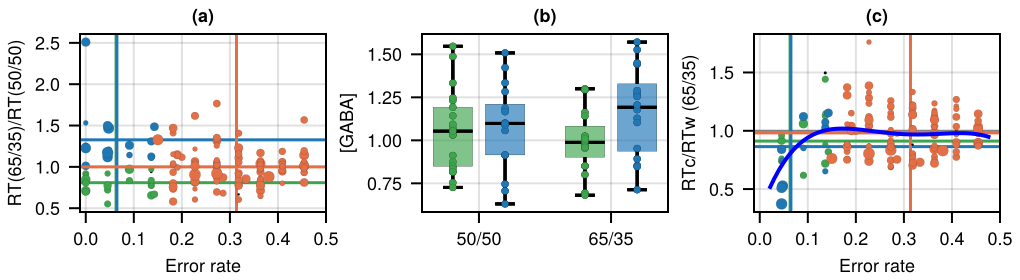

In [8]:
fit_power = 4; #l r b t  #  
fig = Figure(size=(510, 140), fontsize=9, figure_padding=(3, 10, 3, 3)); ax = [];  #400, 300
push!(ax, Axis(fig[1, 1], xlabel="Error rate", ylabel="RT(65/35)/RT(50/50)", title="(a)"));
push!(ax, Axis(fig[1, 3], xlabel="Error rate", ylabel="RTc/RTw (65/35)", title="(c)"));
push!(ax, Axis(fig[1, 2], xlabel="", ylabel="[GABA]", title="(b)"));
[hlines!(axi, [1], color=:gray, linewidth=1) for axi in ax[1:2]]
for group in [2,1,3] #groups
    dfgaba = df_group1[df_group1.group_error .== group, :];
    marker_z = dfgaba.GABA_task; ms = 8 * marker_z ./ nanmaximum(df_group1.GABA_task);    ms[isnan.(ms)] .= nanminimum(ms)-1.5;
    color_z = [isnan(x) ? :black : c[group] for x in marker_z];
    #println("group = $group, ms = $((minimum(ms), maximum(ms)))")
    error_line  =nanmean(dfgaba.error);       GABA_task_line  =nanmean(dfgaba.GABA_task);
    rt_mean_line=nanmean(dfgaba.rt_mean);     rt_unbiased_line=nanmean(dfgaba.rt_unbiased)
    rt_norm_line=nanmean(dfgaba.rt_norm);     ratio_cw_line   =nanmean(dfgaba.ratio_cw);
    GABA_rest_line=nanmean(dfgaba.GABA_rest); EI_task_line    =nanmean(dfgaba.EI_task);
    ratioGABA_taskrest_line=nanmean(dfgaba.ratioGABA_taskrest)

    vlines!(ax[1], [error_line],    linewidth=1.5, color=c[group])
    hlines!(ax[1], [rt_norm_line],  linewidth=1.5, color=c[group])
    vlines!(ax[2], [error_line],    linewidth=1.5, color=c[group])
    hlines!(ax[2], [ratio_cw_line], linewidth=1.5, color=c[group])
    scatter!(ax[1], dfgaba.error, dfgaba.rt_norm, markersize=ms, color=color_z, strokewidth=0.05)
    scatter!(ax[2], dfgaba[.~isnan.(dfgaba.ratio_cw), :].error, dfgaba[.~isnan.(dfgaba.ratio_cw), :].ratio_cw, markersize=ms[.~isnan.(dfgaba.ratio_cw)], color=color_z[.~isnan.(dfgaba.ratio_cw)], strokewidth=0.05)

    #rainclouds!(ax[3], group_array, GABA_array, plot_boxplots=true, boxplot_width=0.18, markersize=5, strokewidth=0.05, clouds=hist, color = colors)
    boxplot!(ax[3], group_array, GABA_array, color=colors_box, width=0.8, show_outliers=false, strokewidth=0.05, whiskerwidth=0.5)#,  markerstrokewidth=0.05, markersize=5)
    scatter!(ax[3], group_array, GABA_array, markersize=5, color=colors,  strokewidth=0.05)
if true
    println("""group $(group), size=$(size(dfgaba))    $(c[group])
    error=$(        round(error_line,              digits=3)) ± $(round(nanse(dfgaba.error),              digits=3)); size=$(nanlength(dfgaba.error))
    RTmean=$(       round(rt_mean_line,            digits=3)) ± $(round(nanse(dfgaba.rt_mean),            digits=3)); size=$(nanlength(dfgaba.rt_mean))
    RTnorm=$(       round(rt_norm_line,            digits=3)) ± $(round(nanse(dfgaba.rt_norm),            digits=3)); size=$(nanlength(dfgaba.rt_norm))
    RTunbiased=$(   round(rt_unbiased_line,        digits=3)) ± $(round(nanse(dfgaba.rt_unbiased),        digits=3)); size=$(nanlength(dfgaba.rt_unbiased))
    ratio_cw=$(     round(ratio_cw_line,           digits=3)) ± $(round(nanse(dfgaba.ratio_cw),           digits=3)); size=$(nanlength(dfgaba.ratio_cw))
    GABA_task=$(    round(GABA_task_line,          digits=3)) ± $(round(nanse(dfgaba.GABA_task),          digits=3)); size=$(nanlength(dfgaba.GABA_task))
    GABA_rest=$(    round(GABA_rest_line,          digits=3)) ± $(round(nanse(dfgaba.GABA_rest),          digits=3)); size=$(nanlength(dfgaba.GABA_rest))
    GABA_taskrest=$(round(ratioGABA_taskrest_line, digits=3)) ± $(round(nanse(dfgaba.ratioGABA_taskrest), digits=3)); size=$(nanlength(dfgaba.ratioGABA_taskrest))
    """) end
end
begin
    er = df_group1.error[.~isnan.(df_group1.ratio_cw), :];
    ratio = df_group1.ratio_cw[.~isnan.(df_group1.ratio_cw), :];
    cor_cw, pcor_cw, acw, bcw = regr_coef(er, ratio);
    fit = curve_fit(Polynomial, er, ratio[:], fit_power);
    x_fit = 0.02:0.01:0.48; ratio_fit = fit.(x_fit);
    lines!(ax[2], x_fit, ratio_fit, linewidth=2, color=:blue)
end
[xlims!(axi,[-0.012, 0.5]) for axi in ax[1:2]];    [axi.xticks=0:0.1:0.5 for axi in ax[1:2]];
ax[3].xticks=([mean(xticks[1:2]), mean(xticks[3:4])], ["50/50", "65/35"]); 
rowgap!(fig.layout, 3); colgap!(fig.layout, 6)
#ylims!(ax[3], (0.6, 1.87)); # ax[3].yticks = 0:0.2:1.2;  
#lines!(ax[3], [mean(xticks[1:2])-0.5, mean(xticks[3:4])-0.5], ones(2)*1.71, color=:black, linewidth=1.5)
#lines!(ax[3], [mean(xticks[1:2])+0.5, mean(xticks[3:4])+0.5], ones(2)*1.77, color=:black, linewidth=1.5)
#text!(ax[3], [mean(xticks[1:2]), mean(xticks[3:4])], [1.76, 1.82], text=["p₂₆=0.16", "p₂₄=0.07"], fontsize=16, align=(:center,:center), color=:black)
fig

## Calculate GABA(blue) / GABA(green) ratio

In [9]:
ratioGABA_highlowRT = nanmean(df_group1[df_group1.group_error .== 1, :].GABA_task) ./ nanmean(df_group1[df_group1.group_error .== 2, :].GABA_task)
ratio3550_highlowRT = nanmean(df_group1[df_group1.group_error .== 1, :].rt_norm)   ./ nanmean(df_group1[df_group1.group_error .== 2, :].rt_norm)
ratioRT35_highlowRT = nanmean(df_group1[df_group1.group_error .== 1, :].rt_mean)   ./ nanmean(df_group1[df_group1.group_error .== 2, :].rt_mean)
println("ratio3550_blue / ratio3550_green = $(round(ratio3550_highlowRT, digits=4))
gaba_blue / gaba_green = $(round(ratioGABA_highlowRT, digits=4))
RT35_blue / RT35_green = $(round(ratioRT35_highlowRT, digits=4))   ")

a = nanmean(df_group1[df_group1.group_error .== 1, :].GABA_task); b = nanmean(df_group1[df_group1.group_error .== 2, :].GABA_task);
da = nanse(df_group1[df_group1.group_error .== 1, :].GABA_task); db = nanse(df_group1[df_group1.group_error .== 2, :].GABA_task);
delta_GABA35task = (a*db + b*da) / (b^2);
println("a = $(round(a, digits=4)) ± $(round(da, digits=4))
b = $(round(b, digits=4)) ± $(round(db, digits=4)) 
gaba_blue / gaba_green = $(round(a/b, digits=4)) ± $(round(delta_GABA35task, digits=4))
std = $(round(delta_GABA35task/(a/b), digits=4)) * mean")

ratio3550_blue / ratio3550_green = 1.6417
gaba_blue / gaba_green = 1.1698
RT35_blue / RT35_green = 1.3305   
a = 1.1675 ± 0.0651
b = 0.998 ± 0.0418 
gaba_blue / gaba_green = 1.1698 ± 0.1142
std = 0.0976 * mean


## Calculate RT(blue)/RT(green) ratio

In [10]:
a = nanmean(df_group1[df_group1.group_error .== 1, :].rt_mean); b = nanmean(df_group1[df_group1.group_error .== 2, :].rt_mean);
da = nanse(df_group1[df_group1.group_error .== 1, :].rt_mean); db = nanse(df_group1[df_group1.group_error .== 2, :].rt_mean);
delta_ratioRT35 = (a*db + b*da) / (b^2);
println("a = $(round(a, digits=4)) ± $(round(da, digits=4))
b = $(round(b, digits=4)) ± $(round(db, digits=4)) 
RT_blue / RT_green = $(round(a/b, digits=4)) ± $(round(delta_ratioRT35, digits=4))
std = $(round(delta_ratioRT35/(a/b), digits=4)) * mean")

a = 0.7853 ± 0.0601
b = 0.5903 ± 0.0457 
RT_blue / RT_green = 1.3305 ± 0.2048
std = 0.1539 * mean


## IIM fitting

In [11]:
## Load data from IIM simulations
L = 40; 
IC = "ZERO";
ic = lowercase(IC);
file_name="./03_data_IIM_simulations/IIM1D_$(IC)_error_rt_vel_etas_0.0_1.0_Ts_0.01_0.85_bias_0.0_2.28_L_$(L)_iter_3000_234000"
df_raw = DataFrame(File(file_name*".csv"));
etas = sort(unique(df_raw.eta));          Ts   = sort(unique(df_raw.T));     
Tmax = 0.64; Ts = Ts[Ts .≤ Tmax];
println(size(df_raw))
df_raw = df_raw[(df_raw.eta .∈ Ref(etas)) .&& (df_raw.T .∈ Ref(Ts)), :];
println(size(df_raw))
println(names(df_raw))

(885753, 15)
(743004, 15)
["eta", "T", "bias", "error", "rt", "rt_cw", "rt_cor", "rt_error", "Vmode", "Vmean", "Vmode_cor", "Vmean_cor", "Vmode_error", "Vmean_error", "iterations"]


In [12]:
# save the data of the green group (2)
group_id = 2; #2 - green, 1 - blue, 3 - red
print("group id: $(group_id)")
df = df_group1[df_group1.group_error .== group_id, :]; ## we select the green group to fit the data

## Here notation of parameters does not match the notation in the paper
## we refer "gain" to the biased condition 65/35 and "loss" to the unbiased condition 50/50
## as this scrip was initially written for the experiment with intermized trials (gain and loss in 70/30 condition)
 ## average quantities for the green group:
error_gain, ratio_rt, ratio_cw_gain = nanmean(df.error), nanmean(df.rt_norm), nanmean(df.ratio_cw);
errorbarg, rtbar  = nanse(df.error), nanse(df.rt_norm);
rtcrtw_green    = nanmean(df_group1[df_group1.group_error .== group_id, :ratio_cw]);
rtcrtwbar_green = nanse(df_group1[df_group1.group_error .== group_id, :ratio_cw]);
ebar_hmap = 0.03; ## error bar for the heatmaps. We use averaging to smooth the data from simulations
df_gain = df_raw[abs.(df_raw.error .- error_gain) .< ebar_hmap, :]; ## green group, we fit the mean error rate of the green group in 65/35 condition
df_loss = df_raw[df_raw.bias .≈ 0, :]; ## unbiased condition, we fit the mean error rate of the unbiased condition 50/50
df_gain.ratrt_cw = df_gain.rt_cor ./ df_gain.rt_error;
df_loss.ratrt_cw = df_loss.rt_cor ./ df_loss.rt_error;
sort!(df_gain, [:eta, :T, :bias]);
sort!(df_loss, [:eta, :T, :bias]);
error_loss = nanmean(df_loss.error);  errorbarl = nanstd(df_loss.error); ## error in unbiased condition is expectted to be 0.5

error_gain, errorbarg, ratio_rt, rtbar, error_loss, errorbarl

group id: 2

(0.06307977736549164, 0.013202775237377956, 0.8085512137527299, 0.024567395378039907, 0.4999841621888974, 0.003963164609562331)

In [13]:
dfrt = DataFrame(eta = Float64[], T = Float64[], biasg = Float64[], biasl = Float64[], 
    errorg = Float64[], errorl = Float64[], rtg = Float64[], rtl = Float64[], 
    ratio_rt = Float64[], rt_cor_g = Float64[], rt_cor_l = Float64[], rt_error_g = Float64[], rt_error_l = Float64[],
    ratio_rt_cor_er_g = Float64[], ratio_rt_cor_er_l = Float64[]);

## takes ~ 1min to run
## we create a data frame where for each eta and T, we find the preferences ϵ1 (we call it bias) 
## and behavioral quantities (error, RT, RTc, RTw) for the biased 65/35 (called "gain") and unbiased (called "loss") conditions
## thus, we will be able to exptract the error rates and RT ratios for each point T, eta of the phase diagram
for row_g in eachrow(df_gain)
    for row_l in eachrow(df_loss)
        if (row_g.eta == row_l.eta) && (row_g.T == row_l.T)
            if row_g.T > 0.02
                df2 = DataFrame(eta = row_g.eta, T = row_g.T, 
                    biasg = row_g.bias,      biasl = row_l.bias, 
                    errorg = row_g.error,    errorl = row_l.error, 
                    rtg = row_g.rt,          rtl = row_l.rt, 
                    ratio_rt = row_g.rt ./ row_l.rt,
                    rt_cor_g = row_g.rt_cor, rt_error_g =  row_g.rt_error, 
                    ratio_rt_cor_er_g = row_g.rt_cor ./ row_g.rt_error,
                    rt_cor_l = row_l.rt_cor, rt_error_l = row_l.rt_error, 
                    ratio_rt_cor_er_l = row_l.rt_cor ./ row_l.rt_error
                )

                append!(dfrt,df2)
            end
        end
    end
end

## we filter the data frame to keep only the points with the same error rate and RT ratio as in the green group within the error and RT bars
## we also filter out the points with bias = 0, which are the unbiased points in 50/50 condition
dfrt_dots = dfrt[(abs.(dfrt.ratio_rt .- ratio_rt) .<= rtbar) .& 
    (abs.(dfrt.errorg .- error_gain) .<= errorbarg) .& (dfrt.biasl .== 0), :]
sort(dfrt_dots, [:T, :eta]);
sort!(dfrt, [:eta, :T, :biasg, :biasl]);

## we take T with a step of 0.02
if 0.01 ∈ Ts
    Ts_hmap = Ts[2:2:end]; etas_hmap = etas[1:2:end];
else
    Ts_hmap = Ts; etas_hmap = etas;
end

## save heatmap data as matrices
ratio_gl_hmap      =  fill(NaN, length(Ts_hmap), length(etas_hmap));
ratio_cw_gain_hmap =  fill(NaN, length(Ts_hmap), length(etas_hmap));
ratio_cw_loss_hmap =  fill(NaN, length(Ts_hmap), length(etas_hmap));
bias_gain_hmap     =  fill(NaN, length(Ts_hmap), length(etas_hmap));
bias_loss_hmap     =  fill(NaN, length(Ts_hmap), length(etas_hmap));

for (ind_η, η) in enumerate(etas_hmap)
    for (ind_T, T) in enumerate(Ts_hmap)

        df_etaT_gain = df_gain[(df_gain.eta .== η) .& (df_gain.T .== T), :];
        df_etaT_loss = df_loss[(df_loss.eta .== η) .& (df_loss.T .== T), :];

        bias_gain_hmap[ind_T, ind_η] = mean(df_etaT_gain.bias);
        bias_loss_hmap[ind_T, ind_η] = mean(df_etaT_loss.bias);

        ratio_gl = dfrt[(dfrt.T .== T) .& (dfrt.eta .== η), :].ratio_rt;
        if (length(ratio_gl) > 0) 
            ratio_gl_hmap[ind_T, ind_η] = mean(ratio_gl);
        end
        
        ratio_cw_g = df_etaT_gain.ratrt_cw;
        if (length(ratio_cw_g) > 0) 
            ratio_cw_gain_hmap[ind_T, ind_η] = mean(ratio_cw_g);
            if error_threshold[2] == 0.1
                ratio_cw_gain_hmap[ind_T, ind_η] = nanmean(ratio_cw_g);
            end
        end
        
        ratio_cw_l = df_etaT_loss.ratrt_cw;
        if (length(ratio_cw_l) > 0) 
            ratio_cw_loss_hmap[ind_T, ind_η] = mean(ratio_cw_l);
        end
        
    end
end

In [14]:
#find RTc/RTw for the green group
mean_ratcw_exp = nanmean(df.ratio_cw); median_ratcw_exp = nanmean(df.ratio_cw); 
std_ratcw_exp = nanstd(df.ratio_cw); se_ratcw_exp = nanse(df.ratio_cw);

## we select the data points that match the ratio RTc/RTw of the green group (2)
m_ratcw_exp = mean_ratcw_exp;
dfrt_dots_fixedcw = dfrt_dots; #ratio_rt_cor_er_g
dfrt_dots_fixedcw = dfrt_dots[abs.(dfrt_dots.ratio_rt_cor_er_g .- m_ratcw_exp) .<= se_ratcw_exp, :]; #ratio_rt_cor_er_g
dfrt_dots_fixedcw = dfrt_dots_fixedcw[dfrt_dots_fixedcw.eta .≤ 0.5, :];
mean_ratcw_exp, median_ratcw_exp, std_ratcw_exp, se_ratcw_exp

(0.911650930524243, 0.911650930524243, 0.23440206450142803, 0.06501143558727047)

## RT(65/35, green)/RT(50/50, green) vs. RT(65/35, blue)/RT(50/50, blue)

In [15]:
## we find the behavioral quantities (error, RT, RTc, RTw) for the biased 65/35 condition of the blue group
error_blue     = nanmean(df_group1[df_group1.group_error .== 1, :error]);
errorbar_blue  = nanse(df_group1[df_group1.group_error .== 1, :error]);
rtcrtw_blue    = nanmean(df_group1[df_group1.group_error .== 1, :ratio_cw]);
rtcrtwbar_blue = nanse(df_group1[df_group1.group_error .== 1, :ratio_cw]);
println("error_blue = $(round(error_blue, digits=3)) ± $(round(errorbar_blue, digits=3))")

## now we place the blue group (1) on the phase diagram
## we create a data frame with T and etas that fit the green group, 
## then, for each T, we find the elevated eta that matches GABA(blue) / GABA(green) ratio from the experiment
highgaba = DataFrame(); #create df with two sets of points - green and blue
begin
    ## save the green group (2) data: low eta
    highgaba.T = Float64.(dfrt_dots_fixedcw.T);
    highgaba.eta_low = Float64.(dfrt_dots_fixedcw.eta);
    highgaba.error_low    = fill(NaN, size(highgaba.T));
    highgaba.bias_low     = fill(NaN, size(highgaba.T));
    highgaba.rt_low       = fill(NaN, size(highgaba.T));
    highgaba.ratio_cw_low = fill(NaN, size(highgaba.T));
    for row in eachrow(highgaba)
        df_filter = dfrt_dots_fixedcw[(dfrt_dots_fixedcw.T .== row.T) .& (dfrt_dots_fixedcw.eta .== row.eta_low), :];
        row.error_low    = nanmean(df_filter.errorg);
        row.bias_low     = nanmean(df_filter.biasg);
        row.rt_low       = nanmean(df_filter.rtg);
        row.ratio_cw_low = nanmean(df_filter.ratio_rt_cor_er_g	);
    end
    ## find the elevated eta for the blue group: high eta and high GABA
    highgaba.eta_high = etas[findnearest(dfrt_dots_fixedcw.eta .* ratioGABA_highlowRT, etas)];
    highgaba = unique(highgaba);
    sort!(highgaba, [:T, :eta_low])

    ## we find the preferences ϵ1 (we call it bias) that fit the error rate of the blue group
    highgaba.bias_high     = fill(NaN, size(highgaba.T));
    highgaba.ratio_cw_high = fill(NaN, size(highgaba.T));
    highgaba.rt_high       = fill(NaN, size(highgaba.T));
    highgaba.error_high    = fill(NaN, size(highgaba.T));
    for row in eachrow(highgaba)
        df_filter = df_raw[(df_raw.T .== row.T) .& (df_raw.eta .== row.eta_high) .& (abs.(df_raw.error .- error_blue) .<= errorbar_blue), :];
        row.error_high    = nanmean(df_filter.error);
        row.bias_high     = nanmean(df_filter.bias);
        row.ratio_cw_high = nanmean(df_filter.rt_cor ./ df_filter.rt_error);
        row.rt_high       = nanmean(df_filter.rt);
    end
    highgaba.rt_highlow = highgaba.rt_high ./ highgaba.rt_low;
    highgaba = highgaba[.~isnan.(highgaba.error_high), :];
end
size(highgaba)

error_blue = 0.065 ± 0.014


(35, 12)

In [16]:
## We set T, eta to obtain IIM's predictions for RT(65/35) / RT(50/50) and RTc/RTw. 
## See SI fig. S21(d), S22(d): black line
if error_threshold[2] == 0.2    T = 0.28; eta_green = 0.38;    end
if error_threshold[2] == 0.1    T = 0.28; eta_green = 0.36;    end
if error_threshold[2] == 0.15   T = 0.28; eta_green = 0.38;    end
eta_blue = highgaba[(highgaba.T .== T) .& (highgaba.eta_low .== eta_green), :].eta_high;
ratio3550_bluegreen = highgaba[(highgaba.T .== T) .& (highgaba.eta_low .== eta_green), :].rt_highlow; 
error35_green = highgaba[(highgaba.T .== T) .& (highgaba.eta_low .== eta_green), :].error_low; 
error35_blue = highgaba[(highgaba.T .== T) .& (highgaba.eta_low .== eta_green), :].error_high;

df_raw[(df_raw.T .== T) .& (df_raw.eta .== eta_green) .& (abs.(df_raw.error .- error35_green) .< 0.01), :]

df_green = df_raw[(df_raw.T .== T) .& (df_raw.eta .== eta_green), :];
df_blue  = df_raw[(df_raw.T .== T) .& (df_raw.eta .== eta_blue),  :];
rt50_green = df_green[df_green.bias .== 0, :].rt[1];
rt50_blue  = df_blue[df_blue.bias .== 0, :].rt[1];

println(names(df_green))

["eta", "T", "bias", "error", "rt", "rt_cw", "rt_cor", "rt_error", "Vmode", "Vmean", "Vmode_cor", "Vmean_cor", "Vmode_error", "Vmean_error", "iterations"]


## Fig. S6

In [18]:
## save the IIM's data as vectors for simplicity
Ts_highgaba = sort(unique(highgaba.T));
    error_low_vec     = fill(NaN, length(Ts_highgaba));
    error_high_vec    = fill(NaN, length(Ts_highgaba));
    bias_low_vec      = fill(NaN, length(Ts_highgaba));
    bias_high_vec     = fill(NaN, length(Ts_highgaba));
    rthigh_rtlow_vec  = fill(NaN, length(Ts_highgaba));
    ratio_cw_low_vec  = fill(NaN, length(Ts_highgaba));
    ratio_cw_high_vec = fill(NaN, length(Ts_highgaba));

for (indT, T) in enumerate(Ts_highgaba)
    df_filter = highgaba[highgaba.T .== T, :];
    if true 
        df_filter = df_filter[abs.(df_filter.ratio_cw_low .- m_ratcw_exp) .<= se_ratcw_exp, :]; #ratio_rt_cor_er_g
    end
    error_low_vec[indT] = nanmean(df_filter.error_low);
    error_high_vec[indT] = nanmean(df_filter.error_high);
    bias_low_vec[indT] = nanmean(df_filter.bias_low);
    bias_high_vec[indT] = nanmean(df_filter.bias_high);
    rthigh_rtlow_vec[indT] = nanmean(df_filter.rt_high ./ df_filter.rt_low);
    ratio_cw_low_vec[indT] = nanmean(df_filter.ratio_cw_low);
    ratio_cw_high_vec[indT] = nanmean(df_filter.ratio_cw_high);
end

## Find RT(blue)/RT(green)
## we find the limits of the grey area in fig. 6C(iv), where the IIM's prediction fits the experimental ratio
Ts_in_grey = Ts_highgaba[(rthigh_rtlow_vec .≥ ratioRT35_highlowRT-delta_ratioRT35) .& (rthigh_rtlow_vec .≤ ratioRT35_highlowRT+delta_ratioRT35)];

## to plot the purple contour
T1 = Ts_in_grey[Ts_in_grey .> 0.2][1]; 
T2 = Ts_in_grey[Ts_in_grey .> 0.2][end];

RTgrRTbl1 = rthigh_rtlow_vec[Ts_highgaba .== T1][1]; RTgrRTbl2 = rthigh_rtlow_vec[Ts_highgaba .== T2][1];
T1, T2, RTgrRTbl1, RTgrRTbl2
highgaba[highgaba.T .== T2,:eta_low][2], highgaba[highgaba.T .== T2,:eta_high][2]

(0.27, 0.32)

Tscatter = (0.15:0.01:0.36, 0.15, 0.36)


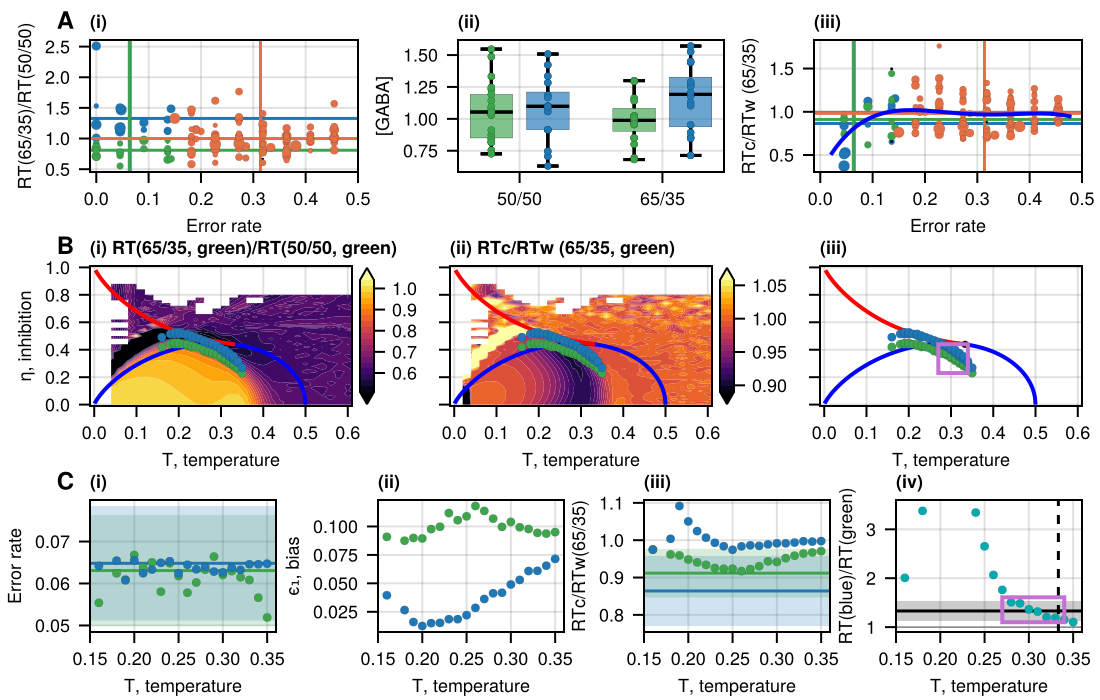

In [19]:
fig = Figure(size=(550, 350), fontsize=9, figure_padding=(3, 9, 3, 3)); ax = []; cf = []; #400, 300 
if true   # A
    ga = fig[1, 1:3] = GridLayout(); ax = [];  
    fit_power = 4; #l r b t  #  
    push!(ax, Axis(ga[1,1], xlabel="Error rate", ylabel="RT(65/35)/RT(50/50)", titlealign=:left, title="(i)",));
    push!(ax, Axis(ga[1,3], xlabel="Error rate", ylabel="RTc/RTw (65/35)",     titlealign=:left, title="(iii)",));
    push!(ax, Axis(ga[1,2], xlabel="",           ylabel="[GABA]",              titlealign=:left, title="(ii)",));
    [hlines!(axi, [1], color=:gray, linewidth=1) for axi in ax[1:2]]
    for group in groups
        dfgaba = df_group1[df_group1.group_error .== group, :];
        marker_z = dfgaba.GABA_task; ms = 8 * marker_z ./ nanmaximum(df_group1.GABA_task);    
        ms[isnan.(ms)] .= nanminimum(ms)-1.5;
        color_z = [isnan(x) ? :black : c[group] for x in marker_z];
        error_line  =nanmean(dfgaba.error);       GABA_task_line  =nanmean(dfgaba.GABA_task);
        rt_mean_line=nanmean(dfgaba.rt_mean);     rt_unbiased_line=nanmean(dfgaba.rt_unbiased)
        rt_norm_line=nanmean(dfgaba.rt_norm);     ratio_cw_line   =nanmean(dfgaba.ratio_cw);
        GABA_rest_line=nanmean(dfgaba.GABA_rest); EI_task_line    =nanmean(dfgaba.EI_task);
        ratioGABA_taskrest_line=nanmean(dfgaba.ratioGABA_taskrest)

        vlines!(ax[1], [error_line],    linewidth=1.5, color=c[group])
        hlines!(ax[1], [rt_norm_line],  linewidth=1.5, color=c[group])
        vlines!(ax[2], [error_line],    linewidth=1.5, color=c[group])
        hlines!(ax[2], [ratio_cw_line], linewidth=1.5, color=c[group])
        scatter!(ax[1], dfgaba.error, dfgaba.rt_norm, markersize=ms, color=color_z, strokewidth=0.05)
        scatter!(ax[2], dfgaba[.~isnan.(dfgaba.ratio_cw), :].error, dfgaba[.~isnan.(dfgaba.ratio_cw), :].ratio_cw, markersize=ms[.~isnan.(dfgaba.ratio_cw)], color=color_z[.~isnan.(dfgaba.ratio_cw)], strokewidth=0.05)

        boxplot!(ax[3], group_array, GABA_array, color=colors_box, width=0.8, show_outliers=false, strokewidth=0.05, whiskerwidth=0.5)
        scatter!(ax[3], group_array, GABA_array, markersize=5, color=colors,  strokewidth=0.05)
    end
    begin
        er = df_group1.error[.~isnan.(df_group1.ratio_cw), :];
        ratio = df_group1.ratio_cw[.~isnan.(df_group1.ratio_cw), :];
        cor_cw, pcor_cw, acw, bcw = regr_coef(er, ratio);
        fit = curve_fit(Polynomial, er, ratio[:], fit_power);
        x_fit = 0.02:0.01:0.48; ratio_fit = fit.(x_fit);
        lines!(ax[2], x_fit, ratio_fit, linewidth=2, color=:blue)
    end
    [xlims!(axi,[-0.012, 0.5]) for axi in ax[1:2]];    [axi.xticks=0:0.1:0.5 for axi in ax[1:2]];
    ax[3].xticks=([mean(xticks[1:2]), mean(xticks[3:4])], ["50/50", "65/35"]);
end
begin   # B
    gb = fig[2, 1:3] = GridLayout(); ax = [];  

    cticks = [0.5:0.1:1.1, 0.9:0.05:1.1]
    push!(ax, Axis(gb[1,1], xlabel="T, temperature", ylabel="η, inhibition", titlealign=:left, title="(i) RT(65/35, green)/RT(50/50, green)",));
    push!(ax, Axis(gb[1,3], xlabel="T, temperature",                         titlealign=:left, title="(ii) RTc/RTw (65/35, green)",  ));
    push!(ax, Axis(gb[1,5], xlabel="T, temperature",                         titlealign=:left, title="(iii)", ));
    push!(cf, contourf!(ax[1], Ts_hmap, etas_hmap, ratio_gl_hmap  ,   extendlow=:auto, extendhigh=:auto, levels=range(0.51, 1.04, length = 20), )); # 0.29:0.05:1.06, 
    push!(cf, contourf!(ax[2], Ts_hmap, etas_hmap, ratio_cw_gain_hmap,extendlow=:auto, extendhigh=:auto, levels=range(0.89, 1.058, length = 20),)); # 0.88:0.05:1.23, 
    [Colorbar(gb[1,2*i], cf[i], size = 7, ticks =cticks[i]) for i in 1:2];
    [lines!(axi, Tblue, ηblue, linewidth=2, color=:blue) for axi in ax];  #  label="1-order tr-n", 
    [lines!(axi, Tred,  ηred,  linewidth=2, color=:red ) for axi in ax];  #  label="2-order tr-n", 
    scatter!(ax[3], [Tcritpoint],[ηcritpoint], marker=:circle, markersize=5, color=:black, strokewidth=0.1)
    [xlims!(axi,[-0.01, 0.61]) for axi in ax]; [ylims!(axi,[-0.01, 1.01]) for axi in ax]; [axi.yticks=0:0.2:1 for axi in ax]
    [scatter!(axi, highgaba.T, highgaba.eta_low, markersize=6, color=c[2], strokewidth=0.05) for axi in ax];
    [scatter!(axi, highgaba.T, highgaba.eta_low .* ratioGABA_highlowRT, markersize=6, color=c[1], strokewidth=0.05) for axi in ax];
    hideydecorations!(ax[2], label = false, ticklabels = true, ticks = false, grid = false, minorgrid = false, minorticks = false)
    hideydecorations!(ax[3], label = false, ticklabels = true, ticks = false, grid = false, minorgrid = false, minorticks = false)

    deta_purple = 0.03; dt = 0.01; drt = 0.05;
    ddeta = maximum(highgaba[highgaba.T .== T1,:eta_high]) - minimum(highgaba[highgaba.T .== T2,:eta_low]);
    poly!(ax[3], [Rect(T1-dt, minimum(highgaba[highgaba.T .== T2,:eta_low])-deta_purple, T2-T1+dt, ddeta+deta_purple)], color=(:white, 0), strokecolor=c[4], strokewidth = 2)
end
begin   # C
    gc = fig[3, 1:3] = GridLayout(); #ax = [];  
        push!(ax, Axis(gc[1,1], xlabel="T, temperature", ylabel="Error rate",         titlealign=:left, title="(i)"));
        push!(ax, Axis(gc[1,2], xlabel="T, temperature", ylabel="ϵ₁, bias",           titlealign=:left, title="(ii)")); 
        push!(ax, Axis(gc[1,3], xlabel="T, temperature", ylabel="RTc/RTw(65/35)",     titlealign=:left, title="(iii)")); 
        push!(ax, Axis(gc[1,4], xlabel="T, temperature", ylabel="RT(blue)/RT(green)", titlealign=:left, title="(iv)"));

    Tscatter = minimum(highgaba.T)-0.01 : 0.01 : maximum(highgaba.T)+0.01;
        println("Tscatter = $((Tscatter, Tscatter[1], Tscatter[end]))")
        band!(ax[4], Tscatter, (error_gain+errorbarg)*ones(length(Tscatter)), (error_gain-errorbarg)*ones(length(Tscatter)), color=(c[2], 0.2))
        band!(ax[4], Tscatter, (error_blue+errorbar_blue)*ones(length(Tscatter)), (error_blue-errorbar_blue)*ones(length(Tscatter)), color=(c[1], 0.2))
        hlines!(ax[4], [error_gain, error_blue], color=[c[2], c[1]], linewidth=1.5)
        scatter!(ax[4], Ts_highgaba, error_low_vec , markersize=6, color=c[2], strokewidth=0.05)
        scatter!(ax[4], Ts_highgaba, error_high_vec, markersize=6, color=c[1], strokewidth=0.05)

    scatter!(ax[5], Ts_highgaba, bias_low_vec , markersize=6, color=c[2], strokewidth=0.05)
    scatter!(ax[5], Ts_highgaba, bias_high_vec, markersize=6, color=c[1], strokewidth=0.05)
    
    band!(ax[6], Tscatter, (rtcrtw_green+rtcrtwbar_green)*ones(length(Tscatter)), (rtcrtw_green-rtcrtwbar_green)*ones(length(Tscatter)), color=(c[2], 0.2))
        band!(ax[6], Tscatter, (rtcrtw_blue+rtcrtwbar_blue)*ones(length(Tscatter)), (rtcrtw_blue-rtcrtwbar_blue)*ones(length(Tscatter)), color=(c[1], 0.2))
        hlines!(ax[6], [rtcrtw_green, rtcrtw_blue], color=[c[2], c[1]], linewidth=1.5)
        scatter!(ax[6], Ts_highgaba, ratio_cw_low_vec , markersize=6, color=c[2], strokewidth=0.05)
        scatter!(ax[6], Ts_highgaba, ratio_cw_high_vec, markersize=6, color=c[1], strokewidth=0.05)

    hlines!(ax[7], [1], linewidth=0.5, color=:grey35)
    vlines!(ax[7], [Tcritpoint], color=:black, linewidth=1.5, linestyle=:dash)
        band!(ax[7], Tscatter, (ratioRT35_highlowRT+delta_ratioRT35)*ones(length(Tscatter)), 
                    (ratioRT35_highlowRT-delta_ratioRT35)*ones(length(Tscatter)), color=(:black, 0.2))
        hlines!(ax[7], [ratioRT35_highlowRT], linewidth=1.5, color=:black)
        scatter!(ax[7], Ts_highgaba, rthigh_rtlow_vec, markersize=6, color=c[6], strokewidth=0.05)
        [xlims!(axi,[Tscatter[1], Tscatter[end]]) for axi in ax[4:7]];  
        ylims!(ax[7], (0.9,3.6));
        dt = 0.01; drt = 0.05; 
        poly!(ax[7], [Rect(T1-dt, RTgrRTbl2-drt, T2-T1+dt, 2*delta_ratioRT35+2*drt)], color=(:white, 0), strokecolor=c[4], strokewidth = 2) #RTgrRTbl2-RTgrRTbl1+2*drt
end
for (label, layout) in zip(["A", "B", "C"], [ga, gb, gc])
    Label(layout[1, 1, TopLeft()], label,
            fontsize = 12,
            font = :bold,
            padding = (0, 8, 3, 0),
            halign = :right)
end
if true # colgap rowgap
    rowgap!(fig.layout, -1); colgap!(fig.layout, 8); 
    colgap!(ga, 8); 
    colgap!(gb, 12); 
    colgap!(gb, 1, 4); 
    colgap!(gb, 3, 4); 
    rowgap!(gc, 5);  colgap!(gc, 3); 
    rowsize!(fig.layout, 2, Relative(0.35));
    #rowsize!(fig.layout, 4, Relative(0.28));
end
resize_to_layout!(fig)
fig

## Similar fig. with IIM's predictions for RT(65/35)/RT(50/50) and RTc/RTw: SI Fig. S21, S22

Tscatter = (0.15:0.01:0.36, 0.15, 0.36)


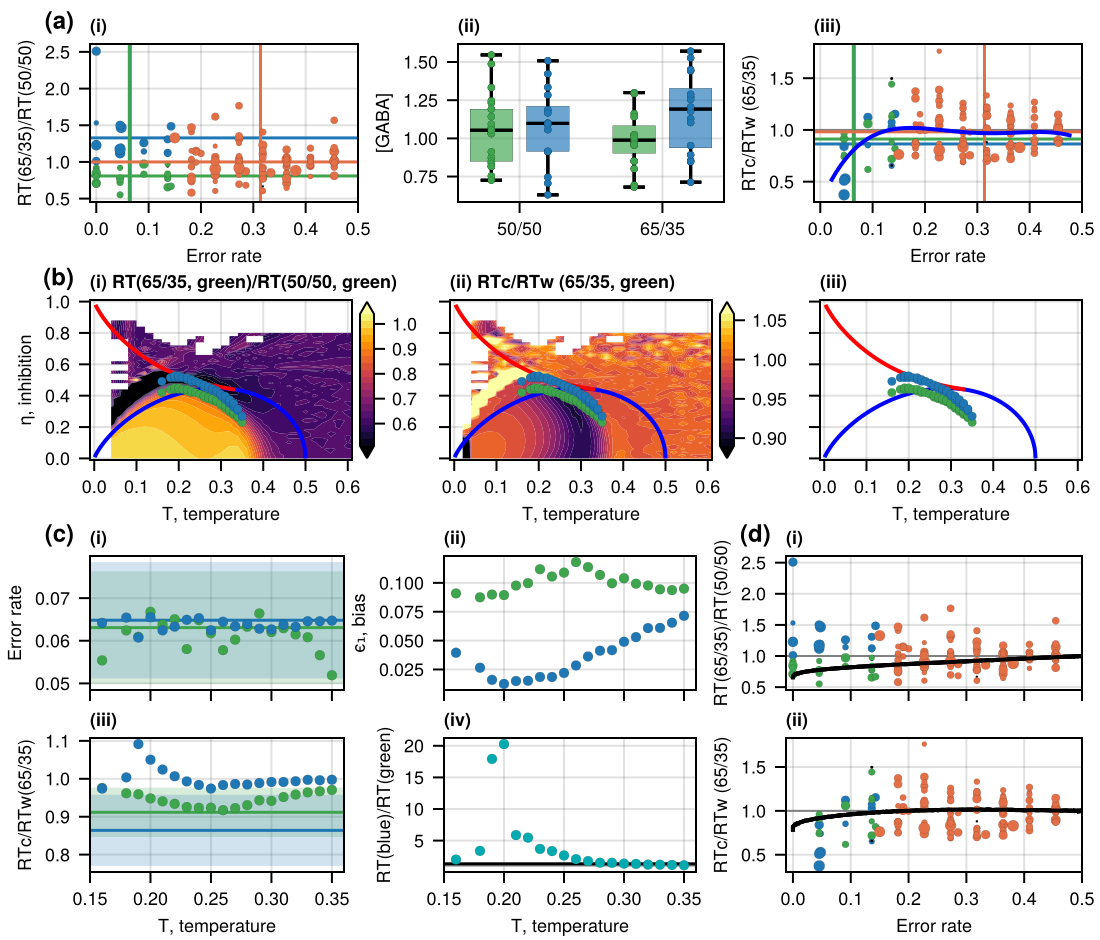

In [23]:
fig = Figure(size=(550, 470), fontsize=9, figure_padding=(3, 9, 3, 3)); ax = []; cf = []; #400, 300 
if true   # A
    ga = fig[1, 1:3] = GridLayout(); ax = [];  
    fit_power = 4; #l r b t  #  
    push!(ax, Axis(ga[1,1], xlabel="Error rate", ylabel="RT(65/35)/RT(50/50)", titlealign=:left, title="(i)",));
    push!(ax, Axis(ga[1,3], xlabel="Error rate", ylabel="RTc/RTw (65/35)",     titlealign=:left, title="(iii)",));
    push!(ax, Axis(ga[1,2], xlabel="",           ylabel="[GABA]",              titlealign=:left, title="(ii)",));
    [hlines!(axi, [1], color=:gray, linewidth=1) for axi in ax[1:2]]
    for group in groups
        dfgaba = df_group1[df_group1.group_error .== group, :];
        marker_z = dfgaba.GABA_task; ms = 8 * marker_z ./ nanmaximum(df_group1.GABA_task);    
        ms[isnan.(ms)] .= nanminimum(ms)-1.5;
        color_z = [isnan(x) ? :black : c[group] for x in marker_z];
        error_line  =nanmean(dfgaba.error);       GABA_task_line  =nanmean(dfgaba.GABA_task);
        rt_mean_line=nanmean(dfgaba.rt_mean);     rt_unbiased_line=nanmean(dfgaba.rt_unbiased)
        rt_norm_line=nanmean(dfgaba.rt_norm);     ratio_cw_line   =nanmean(dfgaba.ratio_cw);
        GABA_rest_line=nanmean(dfgaba.GABA_rest); EI_task_line    =nanmean(dfgaba.EI_task);
        ratioGABA_taskrest_line=nanmean(dfgaba.ratioGABA_taskrest)

        vlines!(ax[1], [error_line],    linewidth=1.5, color=c[group])
        hlines!(ax[1], [rt_norm_line],  linewidth=1.5, color=c[group])
        vlines!(ax[2], [error_line],    linewidth=1.5, color=c[group])
        hlines!(ax[2], [ratio_cw_line], linewidth=1.5, color=c[group])
        scatter!(ax[1], dfgaba.error, dfgaba.rt_norm, markersize=ms, color=color_z, strokewidth=0.05)
        scatter!(ax[2], dfgaba[.~isnan.(dfgaba.ratio_cw), :].error, dfgaba[.~isnan.(dfgaba.ratio_cw), :].ratio_cw, markersize=ms[.~isnan.(dfgaba.ratio_cw)], color=color_z[.~isnan.(dfgaba.ratio_cw)], strokewidth=0.05)

        #rainclouds!(ax[3], group_array, GABA_array, plot_boxplots=true, boxplot_width=0.18, markersize=5, strokewidth=0.05, clouds=hist, color = colors)
        boxplot!(ax[3], group_array, GABA_array, color=colors_box, width=0.8, show_outliers=false, strokewidth=0.05, whiskerwidth=0.5)#,  markerstrokewidth=0.05, markersize=5)
        scatter!(ax[3], group_array, GABA_array, markersize=5, color=colors,  strokewidth=0.05)
    end
    begin
        er = df_group1.error[.~isnan.(df_group1.ratio_cw), :];
        ratio = df_group1.ratio_cw[.~isnan.(df_group1.ratio_cw), :];
        cor_cw, pcor_cw, acw, bcw = regr_coef(er, ratio);
        fit = curve_fit(Polynomial, er, ratio[:], fit_power);
        x_fit = 0.02:0.01:0.48; ratio_fit = fit.(x_fit);
        lines!(ax[2], x_fit, ratio_fit, linewidth=2, color=:blue)
    end
    [xlims!(axi,[-0.012, 0.5]) for axi in ax[1:2]];    [axi.xticks=0:0.1:0.5 for axi in ax[1:2]];
    ax[3].xticks=([mean(xticks[1:2]), mean(xticks[3:4])], ["50/50", "65/35"]);
end
begin   # B
    gb = fig[2, 1:3] = GridLayout(); ax = [];  

    cticks = [0.5:0.1:1.1, 0.9:0.05:1.1]
    push!(ax, Axis(gb[1,1], xlabel="T, temperature", ylabel="η, inhibition", titlealign=:left, title="(i) RT(65/35, green)/RT(50/50, green)",));
    push!(ax, Axis(gb[1,3], xlabel="T, temperature",                         titlealign=:left, title="(ii) RTc/RTw (65/35, green)",  ));
    push!(ax, Axis(gb[1,5], xlabel="T, temperature",                         titlealign=:left, title="(iii)", ));
    push!(cf, contourf!(ax[1], Ts_hmap, etas_hmap, ratio_gl_hmap  ,   extendlow=:auto, extendhigh=:auto, levels=range(0.51, 1.04, length = 20), )); # 0.29:0.05:1.06, 
    push!(cf, contourf!(ax[2], Ts_hmap, etas_hmap, ratio_cw_gain_hmap,extendlow=:auto, extendhigh=:auto, levels=range(0.89, 1.058, length = 20),)); # 0.88:0.05:1.23, 
    [Colorbar(gb[1,2*i], cf[i], size = 7, ticks =cticks[i]) for i in 1:2];
    [lines!(axi, Tblue, ηblue, linewidth=2, color=:blue) for axi in ax];  #  label="1-order tr-n", 
    [lines!(axi, Tred,  ηred,  linewidth=2, color=:red ) for axi in ax];  #  label="2-order tr-n", 
    [xlims!(axi,[-0.01, 0.61]) for axi in ax]; [ylims!(axi,[-0.01, 1.01]) for axi in ax]; [axi.yticks=0:0.2:1 for axi in ax]
    [scatter!(axi, highgaba.T, highgaba.eta_low, markersize=6, color=c[2], strokewidth=0.05) for axi in ax];
    [scatter!(axi, highgaba.T, highgaba.eta_low .* ratioGABA_highlowRT, markersize=6, color=c[1], strokewidth=0.05) for axi in ax];
    hideydecorations!(ax[2], label = false, ticklabels = true, ticks = false, grid = false, minorgrid = false, minorticks = false)
    hideydecorations!(ax[3], label = false, ticklabels = true, ticks = false, grid = false, minorgrid = false, minorticks = false)
end
begin   # C
    gc = fig[3:4, 1:2] = GridLayout(); #ax = [];  
    push!(ax, Axis(gc[1,1],                          ylabel="Error rate",         titlealign=:left, title="(i)"));
    push!(ax, Axis(gc[1,2],                          ylabel="ϵ₁, bias",           titlealign=:left, title="(ii)")); 
    push!(ax, Axis(gc[2,1], xlabel="T, temperature", ylabel="RTc/RTw(65/35)",     titlealign=:left, title="(iii)")); 
    push!(ax, Axis(gc[2,2], xlabel="T, temperature", ylabel="RT(blue)/RT(green)", titlealign=:left, title="(iv)"));

    Tscatter = minimum(highgaba.T)-0.01 : 0.01 : maximum(highgaba.T)+0.01;
    println("Tscatter = $((Tscatter, Tscatter[1], Tscatter[end]))")
    band!(ax[4], Tscatter, (error_gain+errorbarg)*ones(length(Tscatter)), (error_gain-errorbarg)*ones(length(Tscatter)), color=(c[2], 0.2))
    band!(ax[4], Tscatter, (error_blue+errorbar_blue)*ones(length(Tscatter)), (error_blue-errorbar_blue)*ones(length(Tscatter)), color=(c[1], 0.2))
    hlines!(ax[4], [error_gain, error_blue], color=[c[2], c[1]], linewidth=1.5)
    scatter!(ax[4], Ts_highgaba, error_low_vec , markersize=7, color=c[2], strokewidth=0.05)
    scatter!(ax[4], Ts_highgaba, error_high_vec, markersize=7, color=c[1], strokewidth=0.05)

    scatter!(ax[5], Ts_highgaba, bias_low_vec , markersize=7, color=c[2], strokewidth=0.05)
    scatter!(ax[5], Ts_highgaba, bias_high_vec, markersize=7, color=c[1], strokewidth=0.05)#, ylims=(0.024, 0.089))

    #scatter!(ax[6], highgaba.T, log10.(highgaba.rt_low),  markersize=7, color=c[2], strokewidth=0.05)
    #scatter!(ax[6], highgaba.T, log10.(highgaba.rt_high), markersize=7, color=c[1], strokewidth=0.05)
    band!(ax[6], Tscatter, (rtcrtw_green+rtcrtwbar_green)*ones(length(Tscatter)), (rtcrtw_green-rtcrtwbar_green)*ones(length(Tscatter)), color=(c[2], 0.2))
    band!(ax[6], Tscatter, (rtcrtw_blue+rtcrtwbar_blue)*ones(length(Tscatter)), (rtcrtw_blue-rtcrtwbar_blue)*ones(length(Tscatter)), color=(c[1], 0.2))
    hlines!(ax[6], [rtcrtw_green, rtcrtw_blue], color=[c[2], c[1]], linewidth=1.5)
    scatter!(ax[6], Ts_highgaba, ratio_cw_low_vec , markersize=7, color=c[2], strokewidth=0.05)
    scatter!(ax[6], Ts_highgaba, ratio_cw_high_vec, markersize=7, color=c[1], strokewidth=0.05)

    hlines!(ax[7], [1], linewidth=0.5, color=:grey35)
    band!(ax[7], Tscatter, (ratioRT35_highlowRT+delta_ratioRT35)*ones(length(Tscatter)), 
                (ratioRT35_highlowRT-delta_ratioRT35)*ones(length(Tscatter)), color=(:black, 0.2))
    hlines!(ax[7], [ratioRT35_highlowRT], linewidth=1.5, color=:black)
    scatter!(ax[7], Ts_highgaba, rthigh_rtlow_vec, markersize=7, color=c[6], strokewidth=0.05)
    #if error_threshold[2] == 0.2 ax[7].yticks=1:0.2:1.6; end
    #if error_threshold[2] == 0.1 ax[7].yticks=1:0.4:10; end
    #if error_threshold[2] == 0.15 ax[7].yticks=[round(ratioRT35_highlowRT, digits=1); 5:5:20]; end
    [xlims!(axi,[Tscatter[1], Tscatter[end]]) for axi in ax[4:7]];   # [axi.xticks=0.15:0.05:0.35 for axi in ax[4:7]];
    hidexdecorations!(ax[4], label = false, ticklabels = true, ticks = false, grid = false, minorgrid = false, minorticks = false)
    hidexdecorations!(ax[5], label = false, ticklabels = true, ticks = false, grid = false, minorgrid = false, minorticks = false)
end
begin   # D
    gd = fig[3:4, 3] = GridLayout(); #ax = [];  
    push!(ax, Axis(gd[1,1],                      ylabel="RT(65/35)/RT(50/50)", titlealign=:left, title="(i)"));
    push!(ax, Axis(gd[2,1], xlabel="Error rate", ylabel="RTc/RTw (65/35)",     titlealign=:left, title="(ii)"));
    [hlines!(axi, [1], color=:gray, linewidth=1) for axi in ax[8:9]]
    for group in groups
        dfgaba = df_group1[df_group1.group_error .== group, :];
        marker_z = dfgaba.GABA_task; ms = 8 * marker_z ./ nanmaximum(df_group1.GABA_task);    ms[isnan.(ms)] .= nanminimum(ms)-1.5;
        color_z = [isnan(x) ? :black : c[group] for x in marker_z];

        scatter!(ax[8], dfgaba.error, dfgaba.rt_norm, markersize=ms, color=color_z, strokewidth=0.05)
        lines!(ax[8], df_green.error, df_green.rt ./ rt50_green, linewidth=2, color=:black)

        scatter!(ax[9], dfgaba[.~isnan.(dfgaba.ratio_cw), :].error, dfgaba[.~isnan.(dfgaba.ratio_cw), :].ratio_cw, markersize=ms[.~isnan.(dfgaba.ratio_cw)], color=color_z[.~isnan.(dfgaba.ratio_cw)], strokewidth=0.05)
        lines!(ax[9], df_green.error, df_green.rt_cor ./ df_green.rt_error, linewidth=2, color=:black)
    end
    [xlims!(axi,[-0.012, 0.5]) for axi in ax[8:9]];    [axi.xticks=0:0.1:0.5 for axi in ax[8:9]];
    hidexdecorations!(ax[8], label = false, ticklabels = true, ticks = false, grid = false, minorgrid = false, minorticks = false)
end
for (label, layout) in zip(["(a)", "(b)", "(c)", "(d)"], [ga, gb, gc, gd])   #["A", "B", "C", "D"]
    Label(layout[1, 1, TopLeft()], label,
            fontsize = 12,
            font = :bold,
            padding = (0, 8, 5, 0),
            halign = :right)
end
if true # colgap rowgap
    rowgap!(fig.layout, -1); colgap!(fig.layout, 8); 
    colgap!(ga, 8); 
    colgap!(gb, 12); 
    colgap!(gb, 1, 4); 
    colgap!(gb, 3, 4); 
    rowgap!(gc, 5);  colgap!(gc, 3); 
    rowgap!(gd, 5); 
    #rowsize!(fig.layout, 3, Relative(0.28));
    #rowsize!(fig.layout, 4, Relative(0.28));
end
resize_to_layout!(fig)
fig

## What happens if the blue group has the same inhibition as the green group? SI Fig. S23(a)

In [25]:
## we first use the IIM's data, obtained before for the elevated eta in the blue group:

## we find the behavioral quantities (error, RT, RTc, RTw) for the biased 65/35 condition of the blue group
error_blue     = nanmean(df_group1[df_group1.group_error .== 1, :error]);
errorbar_blue  = nanse(df_group1[df_group1.group_error .== 1, :error]);
rtcrtw_blue    = nanmean(df_group1[df_group1.group_error .== 1, :ratio_cw]);
rtcrtwbar_blue = nanse(df_group1[df_group1.group_error .== 1, :ratio_cw]);
println("error_blue = $(round(error_blue, digits=3)) ± $(round(errorbar_blue, digits=3))")

## now we place the blue group (1) on the phase diagram
## we create a data frame with T and etas that fit the green group, 
## then, for each T, we find the elevated eta that matches GABA(blue) / GABA(green) ratio from the experiment
highgaba = DataFrame(); #create df with two sets of points - green and blue
begin
    ## save the green group (2) data: low eta
    highgaba.T = Float64.(dfrt_dots_fixedcw.T);
    highgaba.eta_low = Float64.(dfrt_dots_fixedcw.eta);
    highgaba.error_low    = fill(NaN, size(highgaba.T));
    highgaba.bias_low     = fill(NaN, size(highgaba.T));
    highgaba.rt_low       = fill(NaN, size(highgaba.T));
    highgaba.ratio_cw_low = fill(NaN, size(highgaba.T));
    for row in eachrow(highgaba)
        df_filter = dfrt_dots_fixedcw[(dfrt_dots_fixedcw.T .== row.T) .& (dfrt_dots_fixedcw.eta .== row.eta_low), :];
        row.error_low    = nanmean(df_filter.errorg);
        row.bias_low     = nanmean(df_filter.biasg);
        row.rt_low       = nanmean(df_filter.rtg);
        row.ratio_cw_low = nanmean(df_filter.ratio_rt_cor_er_g	);
    end
    ## find the elevated eta for the blue group: high eta and high GABA
    highgaba.eta_high = etas[findnearest(dfrt_dots_fixedcw.eta .* ratioGABA_highlowRT, etas)];
    highgaba = unique(highgaba);
    sort!(highgaba, [:T, :eta_low])

    ## we find the preferences ϵ1 (we call it bias) that fit the error rate of the blue group
    highgaba.bias_high     = fill(NaN, size(highgaba.T));
    highgaba.ratio_cw_high = fill(NaN, size(highgaba.T));
    highgaba.rt_high       = fill(NaN, size(highgaba.T));
    highgaba.error_high    = fill(NaN, size(highgaba.T));
    for row in eachrow(highgaba)
        df_filter = df_raw[(df_raw.T .== row.T) .& (df_raw.eta .== row.eta_high) .& (abs.(df_raw.error .- error_blue) .<= errorbar_blue), :];
        row.error_high    = nanmean(df_filter.error);
        row.bias_high     = nanmean(df_filter.bias);
        row.ratio_cw_high = nanmean(df_filter.rt_cor ./ df_filter.rt_error);
        row.rt_high       = nanmean(df_filter.rt);
    end
    highgaba.rt_highlow = highgaba.rt_high ./ highgaba.rt_low;
    highgaba = highgaba[.~isnan.(highgaba.error_high), :];
end
size(highgaba)

error_blue = 0.065 ± 0.014


(35, 12)

In [26]:
## then, we use the same low preference ϵ1 (called bias here) as was formed with high eta, 
## with it, we use low eta as in the green group to obtain new error, RT, RTc, RTw
deps = 0.001;
begin
    highgaba.eta_high_bias      = deepcopy(highgaba.eta_high);
    highgaba.eta_high           = deepcopy(highgaba.eta_low);

    for row in eachrow(highgaba)
        df_filter = df_raw[(df_raw.T .== row.T) .&& (df_raw.eta .== row.eta_high) .&& abs.(df_raw.bias .- row.bias_high) .≤ deps, :]; #use bias from higher eta, find new error
        row.error_high    = nanmean(df_filter.error);
        row.ratio_cw_high = nanmean(df_filter.rt_cor ./ df_filter.rt_error);
        row.rt_high       = nanmean(df_filter.rt);
    end
    highgaba.rt_highlow = highgaba.rt_high ./ highgaba.rt_low;
    println(size(highgaba))
end

Ts_highgaba = sort(unique(highgaba.T));
    error_low_vec     = fill(NaN, length(Ts_highgaba));
    error_high_vec    = fill(NaN, length(Ts_highgaba));
    bias_low_vec      = fill(NaN, length(Ts_highgaba));
    bias_high_vec     = fill(NaN, length(Ts_highgaba));
    rthigh_rtlow_vec  = fill(NaN, length(Ts_highgaba));
    ratio_cw_low_vec  = fill(NaN, length(Ts_highgaba));
    ratio_cw_high_vec = fill(NaN, length(Ts_highgaba));

for (indT, T) in enumerate(Ts_highgaba)
    df_filter = highgaba[highgaba.T .== T, :];
    #dfrt_dots_fixedcw = dfrt_dots[abs.(dfrt_dots.ratio_rt_cor_er_g .- m_ratcw_exp) .<= se_ratcw_exp, :]; #ratio_rt_cor_er_g
    if true 
        df_filter = df_filter[abs.(df_filter.ratio_cw_low .- m_ratcw_exp) .<= se_ratcw_exp, :]; #ratio_rt_cor_er_g
    end
    error_low_vec[indT] = nanmean(df_filter.error_low);
    error_high_vec[indT] = nanmean(df_filter.error_high);
    bias_low_vec[indT] = nanmean(df_filter.bias_low);
    bias_high_vec[indT] = nanmean(df_filter.bias_high);
    rthigh_rtlow_vec[indT] = nanmean(df_filter.rt_high ./ df_filter.rt_low);
    ratio_cw_low_vec[indT] = nanmean(df_filter.ratio_cw_low);
    ratio_cw_high_vec[indT] = nanmean(df_filter.ratio_cw_high);
end

## save behavioral data for all three groups:
errors_groups_vec = [];
errors_std_groups_vec = [];
rts_groups_vec = [];
rts_std_groups_vec = [];

for group in groups
    dfgaba = df_group1[df_group1.group_error .== group, :];
    error_line  =nanmean(dfgaba.error);       GABA_task_line  =nanmean(dfgaba.GABA_task);
    rt_mean_line=nanmean(dfgaba.rt_mean);     rt_unbiased_line=nanmean(dfgaba.rt_unbiased)
    rt_norm_line=nanmean(dfgaba.rt_norm);     ratio_cw_line   =nanmean(dfgaba.ratio_cw);
    GABA_rest_line=nanmean(dfgaba.GABA_rest); EI_task_line    =nanmean(dfgaba.EI_task);
    ratioGABA_taskrest_line=nanmean(dfgaba.ratioGABA_taskrest);

    push!(errors_groups_vec, error_line); push!(errors_std_groups_vec, nanstd(dfgaba.error));
    push!(rts_groups_vec, rt_mean_line); push!(rts_std_groups_vec, nanse(dfgaba.rt_mean));
end

(35, 13)


error threshold = [0.0, 0.15]
Tscatter = (0.15:0.01:0.36, 0.15, 0.36)


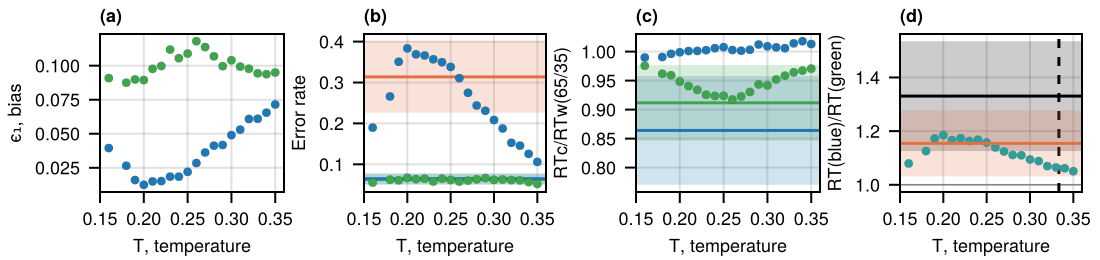

In [27]:
println("error threshold = $error_threshold")
fig = Figure(size=(550, 130), fontsize=9, figure_padding=(3, 9, 3, 3)); ax = []; cf = []; #400, 300 
begin   # C
    gc = fig[1, 1] = GridLayout(); ax = [];  
        push!(ax, Axis(gc[1,2], xlabel="T, temperature", ylabel="Error rate",         titlealign=:left, title="(b)"));
        push!(ax, Axis(gc[1,1], xlabel="T, temperature", ylabel="ϵ₁, bias",           titlealign=:left, title="(a)")); 
        push!(ax, Axis(gc[1,3], xlabel="T, temperature", ylabel="RTc/RTw(65/35)",     titlealign=:left, title="(c)")); 
        push!(ax, Axis(gc[1,4], xlabel="T, temperature", ylabel="RT(blue)/RT(green)", titlealign=:left, title="(d)"));

    Tscatter = minimum(highgaba.T)-0.01 : 0.01 : maximum(highgaba.T)+0.01;
        println("Tscatter = $((Tscatter, Tscatter[1], Tscatter[end]))")
        band!(   ax[1], Tscatter, (error_gain+errorbarg)*ones(length(Tscatter)), (error_gain-errorbarg)*ones(length(Tscatter)), color=(c[2], 0.2))
        band!(   ax[1], Tscatter, (error_blue+errorbar_blue)*ones(length(Tscatter)), (error_blue-errorbar_blue)*ones(length(Tscatter)), color=(c[1], 0.2))
        band!(   ax[1], Tscatter, (errors_groups_vec[3]+errors_std_groups_vec[3])*ones(length(Tscatter)), (errors_groups_vec[3]-errors_std_groups_vec[3])*ones(length(Tscatter)), color=(c[3], 0.2))
        hlines!( ax[1], [error_gain, error_blue, errors_groups_vec[3]], color=[c[2], c[1], c[3]], linewidth=1.5)
        scatter!(ax[1], Ts_highgaba, error_low_vec , markersize=6, color=c[2], strokewidth=0.05)
        scatter!(ax[1], Ts_highgaba, error_high_vec, markersize=6, color=c[1], strokewidth=0.05)

    scatter!(ax[2], Ts_highgaba, bias_low_vec , markersize=6, color=c[2], strokewidth=0.05)
    scatter!(ax[2], Ts_highgaba, bias_high_vec, markersize=6, color=c[1], strokewidth=0.05)#, ylims=(0.024, 0.089))

    band!(       ax[3], Tscatter, (rtcrtw_green+rtcrtwbar_green)*ones(length(Tscatter)), (rtcrtw_green-rtcrtwbar_green)*ones(length(Tscatter)), color=(c[2], 0.2))
        band!(   ax[3], Tscatter, (rtcrtw_blue+rtcrtwbar_blue)*ones(length(Tscatter)), (rtcrtw_blue-rtcrtwbar_blue)*ones(length(Tscatter)), color=(c[1], 0.2))
        hlines!( ax[3], [rtcrtw_green, rtcrtw_blue], color=[c[2], c[1]], linewidth=1.5)
        scatter!(ax[3], Ts_highgaba, ratio_cw_low_vec , markersize=6, color=c[2], strokewidth=0.05)
        scatter!(ax[3], Ts_highgaba, ratio_cw_high_vec, markersize=6, color=c[1], strokewidth=0.05)

    hlines!(    ax[4], [1], linewidth=0.5, color=:grey35)
    vlines!(    ax[4], [Tcritpoint], color=:black, linewidth=1.5, linestyle=:dash)
        band!(  ax[4], Tscatter, (ratioRT35_highlowRT+delta_ratioRT35)*ones(length(Tscatter)), 
                    (ratioRT35_highlowRT-delta_ratioRT35)*ones(length(Tscatter)), color=(:black, 0.2))
        hlines!( ax[4], [ratioRT35_highlowRT], linewidth=1.5, color=:black)
        scatter!(ax[4], Ts_highgaba, rthigh_rtlow_vec, markersize=6, color=c[6], strokewidth=0.05)
        
        rt_orange = rts_groups_vec[3]; rt_orange_std = rts_std_groups_vec[3];
        rt_green  = rts_groups_vec[2]; rt_green_std  = rts_std_groups_vec[2];
        delta_or_gr = (rt_orange_std * rt_green + rt_orange * rt_green_std) / rt_green^2;
        band!(  ax[4], Tscatter, (rt_orange / rt_green+delta_or_gr)*ones(length(Tscatter)), 
        (rt_orange / rt_green-delta_or_gr)*ones(length(Tscatter)), color=(c[3], 0.2))
        hlines!( ax[4], [rt_orange / rt_green], linewidth=1.5, color=c[3])

        [xlims!(axi,[Tscatter[1], Tscatter[end]]) for axi in ax];   
end
if true # colgap rowgap
    rowgap!(fig.layout, -1); colgap!(fig.layout, 8); 
    rowgap!(gc, 5);  colgap!(gc, 3); 
end
resize_to_layout!(fig)
fig